In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [3]:
# reinforcement learning

In [4]:
from baselines.common import set_global_seeds
from baselines import bench
from baselines.common.mpi_fork import mpi_fork
import os.path as osp
import gym, logging
from baselines import logger
import sys

In [5]:
window_length = 50
seed=0
num_timesteps=2e6
save_path= 'outputs/baselines_PPO/{}/'.format('2017-07-22_')

# Env

In [6]:
from src.environments.portfolio import PortfolioEnv
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env_raw = PortfolioEnv(
    df=df_train,
    steps=1440, 
    scale=True, 
    augment=0.0000, # let just overfit first,
    trading_cost=0, # let just overfit first,
    window_length = window_length,
    
) 

# Model

In [7]:
# layer helpers from:
# https://github.com/reinforceio/tensorforce/blob/0d07fadec03f76537a2431e17c51cd759d53b5e9/tensorforce/core/networks/layers.py#L90
import tensorflow as tf
from math import sqrt
from tensorforce import util
from tensorforce import TensorForceError

def linear(x, size, bias=True, l2_regularization=0.0):
    if util.rank(x) != 2:
        raise TensorForceError('Invalid input rank for linear layer.')
    with tf.variable_scope('linear'):
        weights = tf.Variable(initial_value=tf.random_normal(shape=(x.get_shape()[1].value, size), stddev=sqrt(2.0 / (x.get_shape()[1].value + size))))
        if l2_regularization > 0.0:
            tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=weights))
        x = tf.matmul(a=x, b=weights)
        if bias:
            bias = tf.Variable(initial_value=tf.zeros(shape=(size,)))
            if l2_regularization > 0.0:
                tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=bias))
            x = tf.nn.bias_add(value=x, bias=bias)
    return x

def nonlinearity(x, name='relu'):
    with tf.variable_scope('nonlinearity'):
        if name == 'elu':
            x = tf.nn.elu(features=x)
        elif name == 'relu':
            x = tf.nn.relu(features=x)
        elif name == 'selu':
            # https://arxiv.org/pdf/1706.02515.pdf
            alpha = 1.6732632423543772848170429916717
            scale = 1.0507009873554804934193349852946
            negative = alpha * tf.nn.elu(features=x)
            x = scale * tf.where(condition=(x >= 0.0), x=x, y=negative)
        elif name == 'sigmoid':
            x = tf.sigmoid(x=x)
        elif name == 'softmax':
            x = tf.nn.softmax(logits=x)
        elif name == 'tanh':
            x = tf.nn.tanh(x=x)
        else:
            raise TensorForceError('Invalid nonlinearity.')
    return x

def dense(x, size, bias=True, activation='relu', l2_regularization=0.0):
    if util.rank(x) != 2:
        raise TensorForceError('Invalid input rank for dense layer.')
    with tf.variable_scope('dense'):
        x = linear(x=x, size=size, bias=bias, l2_regularization=l2_regularization)
        x = nonlinearity(x=x, name=activation)
    return x

def flatten(x):
    with tf.variable_scope('flatten'):
        x = tf.reshape(tensor=x, shape=(-1, util.prod(x.get_shape().as_list()[1:])))
    return x

def conv2d(x, size, window=(3,3), stride=(1,1), bias=False, activation='relu', l2_regularization=0.0, padding='SAME'):
    if util.rank(x) != 4:
        raise TensorForceError('Invalid input rank for conv2d layer.')
    with tf.variable_scope('conv2d'):
        filters = tf.Variable(initial_value=tf.random_normal(shape=(window[0], window[1], x.get_shape()[3].value, size), stddev=sqrt(2.0 / size)))
        if l2_regularization > 0.0:
            tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=filters))
        x = tf.nn.conv2d(input=x, filter=filters, strides=(1, stride[0], stride[1], 1), padding=padding)
        if bias:
            bias = tf.Variable(initial_value=tf.zeros(shape=(size,)))
            if l2_regularization > 0.0:
                tf.losses.add_loss(l2_regularization * tf.nn.l2_loss(t=bias))
            x = tf.nn.bias_add(value=x, bias=bias)
        x = nonlinearity(x=x, name=activation)
    return x


In [8]:
from baselines.common.mpi_running_mean_std import RunningMeanStd
import baselines.common.tf_util as U
import tensorflow as tf
import gym
from baselines.common.distributions import make_pdtype


class CnnPolicy(object):
    recurrent = False
    def __init__(self, name, ob_space, ac_space, reuse=False):
        with tf.variable_scope(name,  reuse=reuse):
            self._init(ob_space, ac_space)
            self.scope = tf.get_variable_scope().name

    def _init(self, ob_space, ac_space):
        assert isinstance(ob_space, gym.spaces.Box)

        self.pdtype = pdtype = make_pdtype(ac_space)
        sequence_length = None

        ob = U.get_placeholder(name="ob", dtype=tf.float32, shape=[sequence_length] + list(ob_space.shape))
    
        x = ob / 255.0
        
        x = conv2d(x=x, size=2, window=(1,3), bias=True, activation='relu', l2_regularization=1e-8, padding='VALID')
        x = conv2d(x=x, size=20, window=(1,window_length-2), bias=True, activation='relu', l2_regularization=1e-8, padding='VALID')
        x = conv2d(x=x, size=1, window=(1,1), bias=True, activation='relu', l2_regularization=1e-8, padding='VALID')
        x = flatten(x)
        x = dense(x, size=env.action_space.shape[0],activation='relu', l2_regularization=1e-8)
        x = nonlinearity(x,name='softmax')


        logits = U.dense(x, pdtype.param_shape()[0], "logits", U.normc_initializer(0.01))
        self.pd = pdtype.pdfromflat(logits)
        self.vpred = U.dense(x, 1, "value", U.normc_initializer(1.0))[:,0]

        self.state_in = []
        self.state_out = []

        stochastic = tf.placeholder(dtype=tf.bool, shape=())
        ac = self.pd.sample() # XXX
        self._act = U.function([stochastic, ob], [ac, self.vpred])

    def act(self, stochastic, ob):
        ac1, vpred1 =  self._act(stochastic, ob[None])
        return ac1[0], vpred1[0]
    def get_variables(self):
        return tf.get_collection(tf.GraphKeys.VARIABLES, self.scope)
    def get_trainable_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scope)
    def get_initial_state(self):
        return []

    
def policy_fn(name, ob_space, ac_space):  #pylint: disable=W0613
    return CnnPolicy(
        name=name, ob_space=ob_space, ac_space=ac_space)

# Train

In [9]:
from baselines.pposgd import pposgd_simple, cnn_policy, mlp_policy
import baselines.common.tf_util as U


sess = U.single_threaded_session()
sess.__enter__()
logger.session().__enter__()
gym.logger.setLevel(logging.WARN)

env = bench.Monitor(env_raw, osp.join(logger.get_dir(), "%i.monitor.json" % 0))
env.seed(seed)

rank=0
set_global_seeds(seed)

Logging to /tmp/openai-2017-07-23-18-19-06-657524


In [10]:
# U.load_state(os.path.join(save_path, "saved"))

In [11]:
from baselines.common.mpi_adam import MpiAdam
from baselines.common.mpi_moments import mpi_moments
from baselines.common import Dataset, explained_variance, fmt_row, zipsame
from baselines import logger
from collections import deque

In [12]:
# modified from https://github.com/openai/baselines/blob/master/baselines/pposgd/pposgd_simple.py#L90

# env
# policy_fn
max_timesteps=num_timesteps
timesteps_per_batch=256
clip_param=0.2
entcoeff=0.01
optim_epochs=4
optim_stepsize=1e-3
optim_batchsize=64
gamma=0.99
lam=0.95
schedule='linear'
max_episodes=0
max_iters=0
max_seconds=0  # time constraint
callback=None # you can do anything in the callback, since it takes locals(), globals()
        
# Setup losses and stuff
# ----------------------------------------
ob_space = env.observation_space
ac_space = env.action_space
pi = policy_fn("pi", ob_space, ac_space) # Construct network for new policy
oldpi = policy_fn("oldpi", ob_space, ac_space) # Network for old policy
atarg = tf.placeholder(dtype=tf.float32, shape=[None]) # Target advantage function (if applicable)
ret = tf.placeholder(dtype=tf.float32, shape=[None]) # Empirical return

lrmult = tf.placeholder(name='lrmult', dtype=tf.float32, shape=[]) # learning rate multiplier, updated with schedule
clip_param = clip_param * lrmult # Annealed cliping parameter epislon

ob = U.get_placeholder_cached(name="ob")
ac = pi.pdtype.sample_placeholder([None])

kloldnew = oldpi.pd.kl(pi.pd)
ent = pi.pd.entropy()
meankl = U.mean(kloldnew)
meanent = U.mean(ent)
pol_entpen = (-entcoeff) * meanent

ratio = tf.exp(pi.pd.logp(ac) - oldpi.pd.logp(ac)) # pnew / pold
surr1 = ratio * atarg # surrogate from conservative policy iteration
surr2 = U.clip(ratio, 1.0 - clip_param, 1.0 + clip_param) * atarg #
pol_surr = - U.mean(tf.minimum(surr1, surr2)) # PPO's pessimistic surrogate (L^CLIP)
vfloss1 = tf.square(pi.vpred - ret)
vpredclipped = oldpi.vpred + tf.clip_by_value(pi.vpred - oldpi.vpred, -clip_param, clip_param)
vfloss2 = tf.square(vpredclipped - ret)
vf_loss = .5 * U.mean(tf.maximum(vfloss1, vfloss2)) # we do the same clipping-based trust region for the value function
total_loss = pol_surr + pol_entpen + vf_loss
losses = [pol_surr, pol_entpen, vf_loss, meankl, meanent]
loss_names = ["pol_surr", "pol_entpen", "vf_loss", "kl", "ent"]

var_list = pi.get_trainable_variables()
lossandgrad = U.function([ob, ac, atarg, ret, lrmult], losses + [U.flatgrad(total_loss, var_list)])
adam = MpiAdam(var_list)

assign_old_eq_new = U.function([],[], updates=[tf.assign(oldv, newv)
    for (oldv, newv) in zipsame(oldpi.get_variables(), pi.get_variables())])
compute_losses = U.function([ob, ac, atarg, ret, lrmult], losses)

U.initialize()
adam.sync()

# Prepare for rollouts
# ----------------------------------------
seg_gen = pposgd_simple.traj_segment_generator(pi, env, timesteps_per_batch, stochastic=True)

episodes_so_far = 0
timesteps_so_far = 0
iters_so_far = 0
tstart = time.time()
lenbuffer = deque(maxlen=100) # rolling buffer for episode lengths
rewbuffer = deque(maxlen=100) # rolling buffer for episode rewards

assert sum([max_iters>0, max_timesteps>0, max_episodes>0, max_seconds>0])==1, "Only one time constraint permitted"



[2017-07-23 18:19:07,176] VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.


[2017-07-23 18:19:07,179] VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.


In [13]:
from mpi4py import MPI

In [14]:
verbose=False
while True:
    if callback: callback(locals(), globals())
    if max_timesteps and timesteps_so_far >= max_timesteps:
        break
    elif max_episodes and episodes_so_far >= max_episodes:
        break
    elif max_iters and iters_so_far >= max_iters:
        break
    elif max_seconds and time.time() - tstart >= max_seconds:
        break

    if schedule == 'constant':
        cur_lrmult = 1.0
    elif schedule == 'linear':
        cur_lrmult =  max(1.0 - float(timesteps_so_far) / max_timesteps, 0)
    else:
        raise NotImplementedError

    if verbose: logger.log("********** Iteration %i ************"%iters_so_far)

    seg = seg_gen.__next__()
    pposgd_simple.add_vtarg_and_adv(seg, gamma, lam)

    # ob, ac, atarg, ret, td1ret = map(np.concatenate, (obs, acs, atargs, rets, td1rets))
    ob, ac, atarg, tdlamret = seg["ob"], seg["ac"], seg["adv"], seg["tdlamret"]
    vpredbefore = seg["vpred"] # predicted value function before udpate
    atarg = (atarg - atarg.mean()) / atarg.std() # standardized advantage function estimate
    d = Dataset(dict(ob=ob, ac=ac, atarg=atarg, vtarg=tdlamret), shuffle=not pi.recurrent)
    optim_batchsize = optim_batchsize or ob.shape[0]

    if hasattr(pi, "ob_rms"): pi.ob_rms.update(ob) # update running mean/std for policy

    assign_old_eq_new() # set old parameter values to new parameter values
    if verbose: logger.log("Optimizing...")
    if verbose: logger.log(fmt_row(13, loss_names))
    # Here we do a bunch of optimization epochs over the data
    for _ in range(optim_epochs):
        losses = [] # list of tuples, each of which gives the loss for a minibatch
        for batch in d.iterate_once(optim_batchsize):
            *newlosses, g = lossandgrad(batch["ob"], batch["ac"], batch["atarg"], batch["vtarg"], cur_lrmult)
            adam.update(g, optim_stepsize * cur_lrmult) 
            losses.append(newlosses)
        if verbose: logger.log(fmt_row(13, np.mean(losses, axis=0)))

    if verbose: logger.log("Evaluating losses...")
    losses = []
    for batch in d.iterate_once(optim_batchsize):
        newlosses = compute_losses(batch["ob"], batch["ac"], batch["atarg"], batch["vtarg"], cur_lrmult)
        losses.append(newlosses)            
    meanlosses,_,_ = mpi_moments(losses, axis=0)
    if verbose: logger.log(fmt_row(13, meanlosses))
        
    
    for (lossval, name) in zipsame(meanlosses, loss_names):
        logger.record_tabular("loss_"+name, lossval)
    logger.record_tabular("ev_tdlam_before", explained_variance(vpredbefore, tdlamret))
    lrlocal = (seg["ep_lens"], seg["ep_rets"]) # local values
    listoflrpairs = MPI.COMM_WORLD.allgather(lrlocal) # list of tuples
    listoflrpairs = [lrlocal]
    lens, rews = map(pposgd_simple.flatten_lists, zip(*listoflrpairs))
#     lens, rews = [seg["ep_lens"]], [seg["ep_rets"]]
    lenbuffer.extend(lens)
    rewbuffer.extend(rews)
    logger.record_tabular("EpLenMean", np.mean(lenbuffer))
    logger.record_tabular("EpRewMean", np.mean(rewbuffer))
    logger.record_tabular("EpThisIter", len(lens))
    episodes_so_far += len(lens)
    timesteps_so_far += sum(lens)
    iters_so_far += 1
    logger.record_tabular("EpisodesSoFar", episodes_so_far)
    logger.record_tabular("TimestepsSoFar", timesteps_so_far)
    logger.record_tabular("TimeElapsed", time.time() - tstart)
    if episodes_so_far%2==0:
        logger.dump_tabular()

------------------------------
| loss_pol_surr   | -0.00949 |
| loss_pol_entpen | -0.0856  |
| loss_vf_loss    | 1.39e-05 |
| loss_kl         | 0.00168  |
| loss_ent        | 8.56     |
| ev_tdlam_before | 0        |
| EpLenMean       | nan      |
| EpRewMean       | nan      |
| EpThisIter      | 0        |
| EpisodesSoFar   | 0        |
| TimestepsSoFar  | 0        |
| TimeElapsed     | 1.65     |
------------------------------


/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isisilon/.pyenv/versions/3.6.0/envs/jupyter3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


------------------------------
| loss_pol_surr   | -0.004   |
| loss_pol_entpen | -0.0859  |
| loss_vf_loss    | 1.01e-05 |
| loss_kl         | 0.000693 |
| loss_ent        | 8.59     |
| ev_tdlam_before | -0.289   |
| EpLenMean       | nan      |
| EpRewMean       | nan      |
| EpThisIter      | 0        |
| EpisodesSoFar   | 0        |
| TimestepsSoFar  | 0        |
| TimeElapsed     | 3.15     |
------------------------------
------------------------------
| loss_pol_surr   | -0.00613 |
| loss_pol_entpen | -0.0859  |
| loss_vf_loss    | 1.06e-05 |
| loss_kl         | 0.0009   |
| loss_ent        | 8.59     |
| ev_tdlam_before | -0.297   |
| EpLenMean       | nan      |
| EpRewMean       | nan      |
| EpThisIter      | 0        |
| EpisodesSoFar   | 0        |
| TimestepsSoFar  | 0        |
| TimeElapsed     | 4.72     |
------------------------------
------------------------------
| loss_pol_surr   | -0.015   |
| loss_pol_entpen | -0.0861  |
| loss_vf_loss    | 7.72e-06 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00597 |
| loss_pol_entpen | -0.0928  |
| loss_vf_loss    | 1.41e-10 |
| loss_kl         | 0.000967 |
| loss_ent        | 9.28     |
| ev_tdlam_before | 0.000305 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000318 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 6        |
| TimestepsSoFar  | 8.64e+03 |
| TimeElapsed     | 57.6     |
------------------------------
------------------------------
| loss_pol_surr   | -0.00415 |
| loss_pol_entpen | -0.0929  |
| loss_vf_loss    | 7.12e-11 |
| loss_kl         | 0.000346 |
| loss_ent        | 9.29     |
| ev_tdlam_before | -0.00165 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000318 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 6        |
| TimestepsSoFar  | 8.64e+03 |
| TimeElapsed     | 59.1     |
------------------------------
------------------------------
| loss_pol_surr   | -0.00882 |
| loss_pol_entpen | -0.0946  |
| loss_vf_loss    | 1.35e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00475 |
| loss_pol_entpen | -0.0964  |
| loss_vf_loss    | 8.54e-09 |
| loss_kl         | 0.000777 |
| loss_ent        | 9.64     |
| ev_tdlam_before | -0.00312 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000251 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 14       |
| TimestepsSoFar  | 2.02e+04 |
| TimeElapsed     | 114      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00164 |
| loss_pol_entpen | -0.0964  |
| loss_vf_loss    | 1.74e-09 |
| loss_kl         | 0.000209 |
| loss_ent        | 9.64     |
| ev_tdlam_before | -0.0482  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000251 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 14       |
| TimestepsSoFar  | 2.02e+04 |
| TimeElapsed     | 115      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00323 |
| loss_pol_entpen | -0.0964  |
| loss_vf_loss    | 4.14e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00251 |
| loss_pol_entpen | -0.102   |
| loss_vf_loss    | 4.47e-10 |
| loss_kl         | 0.000408 |
| loss_ent        | 10.2     |
| ev_tdlam_before | -0.00409 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000221 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 20       |
| TimestepsSoFar  | 2.88e+04 |
| TimeElapsed     | 162      |
------------------------------
------------------------------
| loss_pol_surr   | -0.0118  |
| loss_pol_entpen | -0.102   |
| loss_vf_loss    | 3.14e-10 |
| loss_kl         | 0.0012   |
| loss_ent        | 10.2     |
| ev_tdlam_before | -0.0292  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000221 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 20       |
| TimestepsSoFar  | 2.88e+04 |
| TimeElapsed     | 164      |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00751  |
| loss_pol_entpen | -0.102    |
| loss_vf_loss    | 6.09e-11  |
| lo

------------------------------
| loss_pol_surr   | -0.00876 |
| loss_pol_entpen | -0.107   |
| loss_vf_loss    | 3.69e-09 |
| loss_kl         | 0.000698 |
| loss_ent        | 10.7     |
| ev_tdlam_before | -0.00403 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000204 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 26       |
| TimestepsSoFar  | 3.74e+04 |
| TimeElapsed     | 210      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00914 |
| loss_pol_entpen | -0.107   |
| loss_vf_loss    | 1.24e-09 |
| loss_kl         | 0.00131  |
| loss_ent        | 10.7     |
| ev_tdlam_before | -0.285   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000204 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 26       |
| TimestepsSoFar  | 3.74e+04 |
| TimeElapsed     | 211      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00485 |
| loss_pol_entpen | -0.108   |
| loss_vf_loss    | 8.61e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00275 |
| loss_pol_entpen | -0.108   |
| loss_vf_loss    | 1.56e-09 |
| loss_kl         | 0.00076  |
| loss_ent        | 10.8     |
| ev_tdlam_before | -0.0696  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000193 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 32       |
| TimestepsSoFar  | 4.61e+04 |
| TimeElapsed     | 258      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00354 |
| loss_pol_entpen | -0.109   |
| loss_vf_loss    | 1.09e-09 |
| loss_kl         | 0.000403 |
| loss_ent        | 10.9     |
| ev_tdlam_before | 0.0108   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000189 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 34       |
| TimestepsSoFar  | 4.9e+04  |
| TimeElapsed     | 267      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00796 |
| loss_pol_entpen | -0.109   |
| loss_vf_loss    | 1.15e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00346 |
| loss_pol_entpen | -0.113   |
| loss_vf_loss    | 7.13e-11 |
| loss_kl         | 0.000425 |
| loss_ent        | 11.3     |
| ev_tdlam_before | -0.00975 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000184 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 40       |
| TimestepsSoFar  | 5.76e+04 |
| TimeElapsed     | 313      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00171 |
| loss_pol_entpen | -0.113   |
| loss_vf_loss    | 3.01e-10 |
| loss_kl         | 0.000297 |
| loss_ent        | 11.3     |
| ev_tdlam_before | -0.0238  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000184 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 40       |
| TimestepsSoFar  | 5.76e+04 |
| TimeElapsed     | 315      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00219 |
| loss_pol_entpen | -0.113   |
| loss_vf_loss    | 4.25e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00545 |
| loss_pol_entpen | -0.115   |
| loss_vf_loss    | 7.77e-11 |
| loss_kl         | 0.000681 |
| loss_ent        | 11.5     |
| ev_tdlam_before | -0.0184  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000201 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 46       |
| TimestepsSoFar  | 6.62e+04 |
| TimeElapsed     | 363      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00491 |
| loss_pol_entpen | -0.116   |
| loss_vf_loss    | 2.14e-10 |
| loss_kl         | 0.000746 |
| loss_ent        | 11.6     |
| ev_tdlam_before | -0.0146  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000201 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 46       |
| TimestepsSoFar  | 6.62e+04 |
| TimeElapsed     | 364      |
------------------------------
------------------------------
| loss_pol_surr   | -0.0109  |
| loss_pol_entpen | -0.116   |
| loss_vf_loss    | 1.25e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00632 |
| loss_pol_entpen | -0.119   |
| loss_vf_loss    | 3.99e-10 |
| loss_kl         | 0.000582 |
| loss_ent        | 11.9     |
| ev_tdlam_before | -0.0439  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000205 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 52       |
| TimestepsSoFar  | 7.49e+04 |
| TimeElapsed     | 412      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00516 |
| loss_pol_entpen | -0.12    |
| loss_vf_loss    | 2.65e-10 |
| loss_kl         | 0.000477 |
| loss_ent        | 12       |
| ev_tdlam_before | -0.0372  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000203 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 54       |
| TimestepsSoFar  | 7.78e+04 |
| TimeElapsed     | 420      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00459 |
| loss_pol_entpen | -0.12    |
| loss_vf_loss    | 7.26e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0126  |
| loss_pol_entpen | -0.129   |
| loss_vf_loss    | 1.18e-10 |
| loss_kl         | 0.0014   |
| loss_ent        | 12.9     |
| ev_tdlam_before | -0.0521  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000223 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 60       |
| TimestepsSoFar  | 8.64e+04 |
| TimeElapsed     | 467      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00813 |
| loss_pol_entpen | -0.128   |
| loss_vf_loss    | 2.56e-10 |
| loss_kl         | 0.0012   |
| loss_ent        | 12.8     |
| ev_tdlam_before | 9.06e-05 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000223 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 60       |
| TimestepsSoFar  | 8.64e+04 |
| TimeElapsed     | 469      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00355 |
| loss_pol_entpen | -0.128   |
| loss_vf_loss    | 3.39e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00624 |
| loss_pol_entpen | -0.131   |
| loss_vf_loss    | 1.18e-10 |
| loss_kl         | 0.000717 |
| loss_ent        | 13.1     |
| ev_tdlam_before | 0.00332  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000218 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 66       |
| TimestepsSoFar  | 9.5e+04  |
| TimeElapsed     | 515      |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00546  |
| loss_pol_entpen | -0.131    |
| loss_vf_loss    | 1.48e-09  |
| loss_kl         | 0.000764  |
| loss_ent        | 13.1      |
| ev_tdlam_before | -0.000801 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000218  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 66        |
| TimestepsSoFar  | 9.5e+04   |
| TimeElapsed     | 517       |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00927 |
| loss_pol_entpen | -0.131   |
| loss_vf_loss    | 2.52e

------------------------------
| loss_pol_surr   | -0.00219 |
| loss_pol_entpen | -0.134   |
| loss_vf_loss    | 1e-10    |
| loss_kl         | 0.000447 |
| loss_ent        | 13.4     |
| ev_tdlam_before | -0.0684  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000211 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 72       |
| TimestepsSoFar  | 1.04e+05 |
| TimeElapsed     | 563      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00617 |
| loss_pol_entpen | -0.134   |
| loss_vf_loss    | 1.54e-10 |
| loss_kl         | 0.00072  |
| loss_ent        | 13.4     |
| ev_tdlam_before | -0.00658 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000211 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 72       |
| TimestepsSoFar  | 1.04e+05 |
| TimeElapsed     | 565      |
------------------------------
------------------------------
| loss_pol_surr   | -0.0046  |
| loss_pol_entpen | -0.135   |
| loss_vf_loss    | 9.52e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00437 |
| loss_pol_entpen | -0.138   |
| loss_vf_loss    | 6.83e-11 |
| loss_kl         | 0.000597 |
| loss_ent        | 13.8     |
| ev_tdlam_before | -0.0512  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000179 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 80       |
| TimestepsSoFar  | 1.15e+05 |
| TimeElapsed     | 619      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00574 |
| loss_pol_entpen | -0.139   |
| loss_vf_loss    | 4.25e-11 |
| loss_kl         | 0.000335 |
| loss_ent        | 13.9     |
| ev_tdlam_before | -0.0181  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000179 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 80       |
| TimestepsSoFar  | 1.15e+05 |
| TimeElapsed     | 620      |
------------------------------
------------------------------
| loss_pol_surr   | -0.0106  |
| loss_pol_entpen | -0.138   |
| loss_vf_loss    | 2.29e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00253 |
| loss_pol_entpen | -0.139   |
| loss_vf_loss    | 4.46e-10 |
| loss_kl         | 0.00025  |
| loss_ent        | 13.9     |
| ev_tdlam_before | 0.000443 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000187 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 86       |
| TimestepsSoFar  | 1.24e+05 |
| TimeElapsed     | 667      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00424 |
| loss_pol_entpen | -0.139   |
| loss_vf_loss    | 1.88e-10 |
| loss_kl         | 0.000314 |
| loss_ent        | 13.9     |
| ev_tdlam_before | -0.0388  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000187 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 86       |
| TimestepsSoFar  | 1.24e+05 |
| TimeElapsed     | 669      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00509 |
| loss_pol_entpen | -0.138   |
| loss_vf_loss    | 1.04e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0129  |
| loss_pol_entpen | -0.146   |
| loss_vf_loss    | 3.06e-09 |
| loss_kl         | 0.00183  |
| loss_ent        | 14.6     |
| ev_tdlam_before | -0.0405  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000194 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 92       |
| TimestepsSoFar  | 1.32e+05 |
| TimeElapsed     | 716      |
------------------------------
------------------------------
| loss_pol_surr   | -0.0078  |
| loss_pol_entpen | -0.146   |
| loss_vf_loss    | 4.8e-10  |
| loss_kl         | 0.0011   |
| loss_ent        | 14.6     |
| ev_tdlam_before | 0.0133   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000194 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 92       |
| TimestepsSoFar  | 1.32e+05 |
| TimeElapsed     | 717      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00216 |
| loss_pol_entpen | -0.147   |
| loss_vf_loss    | 4.32e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00355 |
| loss_pol_entpen | -0.148   |
| loss_vf_loss    | 1.9e-09  |
| loss_kl         | 0.000513 |
| loss_ent        | 14.8     |
| ev_tdlam_before | 3.59e-05 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000204 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 100      |
| TimestepsSoFar  | 1.44e+05 |
| TimeElapsed     | 772      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00666 |
| loss_pol_entpen | -0.149   |
| loss_vf_loss    | 1.74e-09 |
| loss_kl         | 0.000759 |
| loss_ent        | 14.9     |
| ev_tdlam_before | 0.00169  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000204 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 100      |
| TimestepsSoFar  | 1.44e+05 |
| TimeElapsed     | 774      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00445 |
| loss_pol_entpen | -0.149   |
| loss_vf_loss    | 1.89e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00143 |
| loss_pol_entpen | -0.149   |
| loss_vf_loss    | 2.84e-10 |
| loss_kl         | 0.00012  |
| loss_ent        | 14.9     |
| ev_tdlam_before | 0.00152  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000195 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 106      |
| TimestepsSoFar  | 1.53e+05 |
| TimeElapsed     | 820      |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00445  |
| loss_pol_entpen | -0.149    |
| loss_vf_loss    | 9.35e-10  |
| loss_kl         | 0.000388  |
| loss_ent        | 14.9      |
| ev_tdlam_before | -2.31e-05 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000195  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 106       |
| TimestepsSoFar  | 1.53e+05  |
| TimeElapsed     | 821       |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00805 |
| loss_pol_entpen | -0.149   |
| loss_vf_loss    | 1.51e

------------------------------
| loss_pol_surr   | -0.00634 |
| loss_pol_entpen | -0.154   |
| loss_vf_loss    | 4.12e-10 |
| loss_kl         | 0.000872 |
| loss_ent        | 15.4     |
| ev_tdlam_before | -0.00424 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000202 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 112      |
| TimestepsSoFar  | 1.61e+05 |
| TimeElapsed     | 867      |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00663  |
| loss_pol_entpen | -0.154    |
| loss_vf_loss    | 6.44e-10  |
| loss_kl         | 0.000784  |
| loss_ent        | 15.4      |
| ev_tdlam_before | -0.000153 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000202  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 112       |
| TimestepsSoFar  | 1.61e+05  |
| TimeElapsed     | 868       |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000754 |
| loss_pol_entpen | -0.154    |
| loss_vf_loss    | 5.

------------------------------
| loss_pol_surr   | -0.00898 |
| loss_pol_entpen | -0.156   |
| loss_vf_loss    | 4.84e-10 |
| loss_kl         | 0.00121  |
| loss_ent        | 15.6     |
| ev_tdlam_before | -0.221   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000213 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 118      |
| TimestepsSoFar  | 1.7e+05  |
| TimeElapsed     | 916      |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000466 |
| loss_pol_entpen | -0.157    |
| loss_vf_loss    | 1.08e-09  |
| loss_kl         | 5.04e-05  |
| loss_ent        | 15.7      |
| ev_tdlam_before | -0.0195   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00022   |
| EpThisIter      | 1         |
| EpisodesSoFar   | 120       |
| TimestepsSoFar  | 1.73e+05  |
| TimeElapsed     | 924       |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00175 |
| loss_pol_entpen | -0.157   |
| loss_vf_loss    | 1.74e

------------------------------
| loss_pol_surr   | -0.00326 |
| loss_pol_entpen | -0.16    |
| loss_vf_loss    | 7.57e-10 |
| loss_kl         | 0.001    |
| loss_ent        | 16       |
| ev_tdlam_before | 0.00946  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000236 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 126      |
| TimestepsSoFar  | 1.81e+05 |
| TimeElapsed     | 971      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00465 |
| loss_pol_entpen | -0.161   |
| loss_vf_loss    | 6.16e-10 |
| loss_kl         | 0.000607 |
| loss_ent        | 16.1     |
| ev_tdlam_before | -0.0517  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000236 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 126      |
| TimestepsSoFar  | 1.81e+05 |
| TimeElapsed     | 973      |
------------------------------
------------------------------
| loss_pol_surr   | -0.00317 |
| loss_pol_entpen | -0.161   |
| loss_vf_loss    | 5.88e-10 |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000748 |
| loss_pol_entpen | -0.169    |
| loss_vf_loss    | 7.46e-10  |
| loss_kl         | 0.00033   |
| loss_ent        | 16.9      |
| ev_tdlam_before | -0.0679   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00024   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 132       |
| TimestepsSoFar  | 1.9e+05   |
| TimeElapsed     | 1.02e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00876 |
| loss_pol_entpen | -0.17    |
| loss_vf_loss    | 4.41e-10 |
| loss_kl         | 0.000995 |
| loss_ent        | 17       |
| ev_tdlam_before | -0.00559 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00024  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 132      |
| TimestepsSoFar  | 1.9e+05  |
| TimeElapsed     | 1.02e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00993 |
| loss_pol_entpen | -0.17    |
| loss_vf_loss    | 1.09e

------------------------------
| loss_pol_surr   | -0.00146 |
| loss_pol_entpen | -0.173   |
| loss_vf_loss    | 2.92e-10 |
| loss_kl         | 0.000274 |
| loss_ent        | 17.3     |
| ev_tdlam_before | -0.00118 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000239 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 138      |
| TimestepsSoFar  | 1.99e+05 |
| TimeElapsed     | 1.07e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00601 |
| loss_pol_entpen | -0.174   |
| loss_vf_loss    | 5.09e-10 |
| loss_kl         | 0.000474 |
| loss_ent        | 17.4     |
| ev_tdlam_before | -0.0056  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000241 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 140      |
| TimestepsSoFar  | 2.02e+05 |
| TimeElapsed     | 1.08e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00515 |
| loss_pol_entpen | -0.173   |
| loss_vf_loss    | 6.21e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00478 |
| loss_pol_entpen | -0.177   |
| loss_vf_loss    | 2.21e-10 |
| loss_kl         | 0.000432 |
| loss_ent        | 17.7     |
| ev_tdlam_before | 0.00271  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 146      |
| TimestepsSoFar  | 2.1e+05  |
| TimeElapsed     | 1.12e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00107  |
| loss_pol_entpen | -0.177    |
| loss_vf_loss    | 9.72e-11  |
| loss_kl         | 0.00019   |
| loss_ent        | 17.7      |
| ev_tdlam_before | -0.000281 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000248  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 146       |
| TimestepsSoFar  | 2.1e+05   |
| TimeElapsed     | 1.12e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00546 |
| loss_pol_entpen | -0.177   |
| loss_vf_loss    | 5.07e

------------------------------
| loss_pol_surr   | -0.00499 |
| loss_pol_entpen | -0.181   |
| loss_vf_loss    | 1.98e-10 |
| loss_kl         | 0.000722 |
| loss_ent        | 18.1     |
| ev_tdlam_before | -0.00904 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000254 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 152      |
| TimestepsSoFar  | 2.19e+05 |
| TimeElapsed     | 1.17e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00276 |
| loss_pol_entpen | -0.181   |
| loss_vf_loss    | 1.49e-09 |
| loss_kl         | 0.000304 |
| loss_ent        | 18.1     |
| ev_tdlam_before | -0.00852 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000254 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 152      |
| TimestepsSoFar  | 2.19e+05 |
| TimeElapsed     | 1.18e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00804 |
| loss_pol_entpen | -0.181   |
| loss_vf_loss    | 2.46e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00768 |
| loss_pol_entpen | -0.185   |
| loss_vf_loss    | 2.95e-09 |
| loss_kl         | 0.00125  |
| loss_ent        | 18.5     |
| ev_tdlam_before | -0.0523  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00026  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 158      |
| TimestepsSoFar  | 2.28e+05 |
| TimeElapsed     | 1.22e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00335 |
| loss_pol_entpen | -0.185   |
| loss_vf_loss    | 3.47e-09 |
| loss_kl         | 0.000362 |
| loss_ent        | 18.5     |
| ev_tdlam_before | -0.0517  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00026  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 158      |
| TimestepsSoFar  | 2.28e+05 |
| TimeElapsed     | 1.23e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00916 |
| loss_pol_entpen | -0.186   |
| loss_vf_loss    | 1.75e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00349 |
| loss_pol_entpen | -0.186   |
| loss_vf_loss    | 7.68e-10 |
| loss_kl         | 0.000508 |
| loss_ent        | 18.6     |
| ev_tdlam_before | -0.00288 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00026  |
| EpThisIter      | 1        |
| EpisodesSoFar   | 166      |
| TimestepsSoFar  | 2.39e+05 |
| TimeElapsed     | 1.28e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00429 |
| loss_pol_entpen | -0.187   |
| loss_vf_loss    | 1.02e-10 |
| loss_kl         | 0.000458 |
| loss_ent        | 18.7     |
| ev_tdlam_before | -0.0588  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00026  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 166      |
| TimestepsSoFar  | 2.39e+05 |
| TimeElapsed     | 1.28e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00514  |
| loss_pol_entpen | -0.187    |
| loss_vf_loss    | 1.91e-09  |
| lo

------------------------------
| loss_pol_surr   | -0.00701 |
| loss_pol_entpen | -0.191   |
| loss_vf_loss    | 7.52e-11 |
| loss_kl         | 0.00114  |
| loss_ent        | 19.1     |
| ev_tdlam_before | -0.0467  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000273 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 172      |
| TimestepsSoFar  | 2.48e+05 |
| TimeElapsed     | 1.33e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00397 |
| loss_pol_entpen | -0.191   |
| loss_vf_loss    | 4.82e-10 |
| loss_kl         | 0.000703 |
| loss_ent        | 19.1     |
| ev_tdlam_before | 0.00118  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000273 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 172      |
| TimestepsSoFar  | 2.48e+05 |
| TimeElapsed     | 1.33e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00778  |
| loss_pol_entpen | -0.192    |
| loss_vf_loss    | 6.23e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00675 |
| loss_pol_entpen | -0.193   |
| loss_vf_loss    | 3.29e-09 |
| loss_kl         | 0.000601 |
| loss_ent        | 19.3     |
| ev_tdlam_before | -0.302   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000305 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 178      |
| TimestepsSoFar  | 2.56e+05 |
| TimeElapsed     | 1.38e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00607 |
| loss_pol_entpen | -0.193   |
| loss_vf_loss    | 1.73e-09 |
| loss_kl         | 0.000832 |
| loss_ent        | 19.3     |
| ev_tdlam_before | 0.0114   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000305 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 178      |
| TimestepsSoFar  | 2.56e+05 |
| TimeElapsed     | 1.38e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00446 |
| loss_pol_entpen | -0.193   |
| loss_vf_loss    | 2.14e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00233 |
| loss_pol_entpen | -0.194   |
| loss_vf_loss    | 9.09e-11 |
| loss_kl         | 0.000406 |
| loss_ent        | 19.4     |
| ev_tdlam_before | -0.00105 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000301 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 184      |
| TimestepsSoFar  | 2.65e+05 |
| TimeElapsed     | 1.42e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00519  |
| loss_pol_entpen | -0.195    |
| loss_vf_loss    | 4.27e-10  |
| loss_kl         | 0.000415  |
| loss_ent        | 19.5      |
| ev_tdlam_before | -0.000864 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00029   |
| EpThisIter      | 1         |
| EpisodesSoFar   | 186       |
| TimestepsSoFar  | 2.68e+05  |
| TimeElapsed     | 1.43e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00204 |
| loss_pol_entpen | -0.195   |
| loss_vf_loss    | 1.35e

------------------------------
| loss_pol_surr   | -0.00443 |
| loss_pol_entpen | -0.197   |
| loss_vf_loss    | 2.72e-10 |
| loss_kl         | 0.000574 |
| loss_ent        | 19.7     |
| ev_tdlam_before | -0.0537  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000283 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 192      |
| TimestepsSoFar  | 2.76e+05 |
| TimeElapsed     | 1.48e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00438 |
| loss_pol_entpen | -0.197   |
| loss_vf_loss    | 3.51e-10 |
| loss_kl         | 0.00037  |
| loss_ent        | 19.7     |
| ev_tdlam_before | -0.00206 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000283 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 192      |
| TimestepsSoFar  | 2.76e+05 |
| TimeElapsed     | 1.48e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00521 |
| loss_pol_entpen | -0.198   |
| loss_vf_loss    | 1.97e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00231 |
| loss_pol_entpen | -0.2     |
| loss_vf_loss    | 9.73e-10 |
| loss_kl         | 0.0002   |
| loss_ent        | 20       |
| ev_tdlam_before | -0.00397 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000275 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 198      |
| TimestepsSoFar  | 2.85e+05 |
| TimeElapsed     | 1.53e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00729 |
| loss_pol_entpen | -0.2     |
| loss_vf_loss    | 1.31e-09 |
| loss_kl         | 0.000852 |
| loss_ent        | 20       |
| ev_tdlam_before | -0.083   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000275 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 198      |
| TimestepsSoFar  | 2.85e+05 |
| TimeElapsed     | 1.53e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00187 |
| loss_pol_entpen | -0.201   |
| loss_vf_loss    | 1.56e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00513 |
| loss_pol_entpen | -0.202   |
| loss_vf_loss    | 3.84e-10 |
| loss_kl         | 0.000339 |
| loss_ent        | 20.2     |
| ev_tdlam_before | -0.0408  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000278 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 204      |
| TimestepsSoFar  | 2.94e+05 |
| TimeElapsed     | 1.58e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00087 |
| loss_pol_entpen | -0.204   |
| loss_vf_loss    | 7.62e-10 |
| loss_kl         | 0.000112 |
| loss_ent        | 20.4     |
| ev_tdlam_before | -0.00193 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00028  |
| EpThisIter      | 1        |
| EpisodesSoFar   | 206      |
| TimestepsSoFar  | 2.97e+05 |
| TimeElapsed     | 1.58e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00179 |
| loss_pol_entpen | -0.204   |
| loss_vf_loss    | 8.6e-10  |
| loss_k

------------------------------
| loss_pol_surr   | -0.00643 |
| loss_pol_entpen | -0.21    |
| loss_vf_loss    | 1.15e-10 |
| loss_kl         | 0.000883 |
| loss_ent        | 21       |
| ev_tdlam_before | -0.0142  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000279 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 212      |
| TimestepsSoFar  | 3.05e+05 |
| TimeElapsed     | 1.63e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0027  |
| loss_pol_entpen | -0.21    |
| loss_vf_loss    | 1.1e-10  |
| loss_kl         | 0.000508 |
| loss_ent        | 21       |
| ev_tdlam_before | -0.016   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000279 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 212      |
| TimestepsSoFar  | 3.05e+05 |
| TimeElapsed     | 1.63e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00666 |
| loss_pol_entpen | -0.21    |
| loss_vf_loss    | 8.49e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00465 |
| loss_pol_entpen | -0.212   |
| loss_vf_loss    | 2.78e-10 |
| loss_kl         | 0.000623 |
| loss_ent        | 21.2     |
| ev_tdlam_before | 0.000558 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000273 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 218      |
| TimestepsSoFar  | 3.14e+05 |
| TimeElapsed     | 1.68e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00242 |
| loss_pol_entpen | -0.212   |
| loss_vf_loss    | 5.92e-11 |
| loss_kl         | 0.000203 |
| loss_ent        | 21.2     |
| ev_tdlam_before | -0.0123  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000273 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 218      |
| TimestepsSoFar  | 3.14e+05 |
| TimeElapsed     | 1.68e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00506 |
| loss_pol_entpen | -0.212   |
| loss_vf_loss    | 1.82e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00035 |
| loss_pol_entpen | -0.214   |
| loss_vf_loss    | 1.23e-09 |
| loss_kl         | 8.45e-05 |
| loss_ent        | 21.4     |
| ev_tdlam_before | -0.0913  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000263 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 224      |
| TimestepsSoFar  | 3.23e+05 |
| TimeElapsed     | 1.73e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00496 |
| loss_pol_entpen | -0.214   |
| loss_vf_loss    | 1.13e-09 |
| loss_kl         | 0.000497 |
| loss_ent        | 21.4     |
| ev_tdlam_before | -0.387   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000263 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 224      |
| TimestepsSoFar  | 3.23e+05 |
| TimeElapsed     | 1.73e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00575  |
| loss_pol_entpen | -0.213    |
| loss_vf_loss    | 5.75e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00404 |
| loss_pol_entpen | -0.217   |
| loss_vf_loss    | 1.44e-09 |
| loss_kl         | 0.000265 |
| loss_ent        | 21.7     |
| ev_tdlam_before | 0.0148   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000264 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 232      |
| TimestepsSoFar  | 3.34e+05 |
| TimeElapsed     | 1.78e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00348 |
| loss_pol_entpen | -0.217   |
| loss_vf_loss    | 2.6e-10  |
| loss_kl         | 0.000496 |
| loss_ent        | 21.7     |
| ev_tdlam_before | -0.00855 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000264 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 232      |
| TimestepsSoFar  | 3.34e+05 |
| TimeElapsed     | 1.78e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000656 |
| loss_pol_entpen | -0.218    |
| loss_vf_loss    | 5.49e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00475 |
| loss_pol_entpen | -0.222   |
| loss_vf_loss    | 7.54e-10 |
| loss_kl         | 0.000474 |
| loss_ent        | 22.2     |
| ev_tdlam_before | -0.0238  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000279 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 238      |
| TimestepsSoFar  | 3.43e+05 |
| TimeElapsed     | 1.83e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00494 |
| loss_pol_entpen | -0.222   |
| loss_vf_loss    | 1.43e-10 |
| loss_kl         | 0.000529 |
| loss_ent        | 22.2     |
| ev_tdlam_before | 0.00595  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000279 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 238      |
| TimestepsSoFar  | 3.43e+05 |
| TimeElapsed     | 1.83e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00126 |
| loss_pol_entpen | -0.222   |
| loss_vf_loss    | 1.39e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00567 |
| loss_pol_entpen | -0.226   |
| loss_vf_loss    | 4.92e-10 |
| loss_kl         | 0.000717 |
| loss_ent        | 22.6     |
| ev_tdlam_before | 0.00363  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000272 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 244      |
| TimestepsSoFar  | 3.51e+05 |
| TimeElapsed     | 1.88e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00181 |
| loss_pol_entpen | -0.226   |
| loss_vf_loss    | 6.46e-11 |
| loss_kl         | 0.000207 |
| loss_ent        | 22.6     |
| ev_tdlam_before | -0.0214  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000272 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 244      |
| TimestepsSoFar  | 3.51e+05 |
| TimeElapsed     | 1.88e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00272 |
| loss_pol_entpen | -0.226   |
| loss_vf_loss    | 3.85e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00524 |
| loss_pol_entpen | -0.23    |
| loss_vf_loss    | 1.98e-10 |
| loss_kl         | 0.000791 |
| loss_ent        | 23       |
| ev_tdlam_before | -0.0326  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000278 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 252      |
| TimestepsSoFar  | 3.63e+05 |
| TimeElapsed     | 1.94e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00145 |
| loss_pol_entpen | -0.23    |
| loss_vf_loss    | 1.28e-10 |
| loss_kl         | 0.000337 |
| loss_ent        | 23       |
| ev_tdlam_before | -0.0129  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000278 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 252      |
| TimestepsSoFar  | 3.63e+05 |
| TimeElapsed     | 1.94e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00394 |
| loss_pol_entpen | -0.23    |
| loss_vf_loss    | 1.62e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0032  |
| loss_pol_entpen | -0.231   |
| loss_vf_loss    | 1.31e-10 |
| loss_kl         | 0.000518 |
| loss_ent        | 23.1     |
| ev_tdlam_before | -0.0106  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000265 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 258      |
| TimestepsSoFar  | 3.72e+05 |
| TimeElapsed     | 1.98e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00271 |
| loss_pol_entpen | -0.231   |
| loss_vf_loss    | 1.14e-10 |
| loss_kl         | 0.00027  |
| loss_ent        | 23.1     |
| ev_tdlam_before | -0.00965 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000265 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 258      |
| TimestepsSoFar  | 3.72e+05 |
| TimeElapsed     | 1.98e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00452  |
| loss_pol_entpen | -0.231    |
| loss_vf_loss    | 8.62e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00578 |
| loss_pol_entpen | -0.233   |
| loss_vf_loss    | 2.61e-09 |
| loss_kl         | 0.000745 |
| loss_ent        | 23.3     |
| ev_tdlam_before | -0.301   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000262 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 264      |
| TimestepsSoFar  | 3.8e+05  |
| TimeElapsed     | 2.03e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00979 |
| loss_pol_entpen | -0.233   |
| loss_vf_loss    | 1.29e-10 |
| loss_kl         | 0.000701 |
| loss_ent        | 23.3     |
| ev_tdlam_before | -0.333   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000262 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 264      |
| TimestepsSoFar  | 3.8e+05  |
| TimeElapsed     | 2.03e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00207 |
| loss_pol_entpen | -0.233   |
| loss_vf_loss    | 4.79e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0048  |
| loss_pol_entpen | -0.235   |
| loss_vf_loss    | 2.82e-10 |
| loss_kl         | 0.000621 |
| loss_ent        | 23.5     |
| ev_tdlam_before | -0.00774 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 270      |
| TimestepsSoFar  | 3.89e+05 |
| TimeElapsed     | 2.08e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0037  |
| loss_pol_entpen | -0.234   |
| loss_vf_loss    | 3.21e-09 |
| loss_kl         | 0.000351 |
| loss_ent        | 23.4     |
| ev_tdlam_before | -0.148   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000257 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 272      |
| TimestepsSoFar  | 3.92e+05 |
| TimeElapsed     | 2.09e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00592 |
| loss_pol_entpen | -0.234   |
| loss_vf_loss    | 1.01e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00289 |
| loss_pol_entpen | -0.236   |
| loss_vf_loss    | 1.25e-10 |
| loss_kl         | 0.000262 |
| loss_ent        | 23.6     |
| ev_tdlam_before | -0.0845  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000257 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 278      |
| TimestepsSoFar  | 4e+05    |
| TimeElapsed     | 2.14e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00563 |
| loss_pol_entpen | -0.236   |
| loss_vf_loss    | 2.65e-10 |
| loss_kl         | 0.000664 |
| loss_ent        | 23.6     |
| ev_tdlam_before | -0.00305 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000257 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 278      |
| TimestepsSoFar  | 4e+05    |
| TimeElapsed     | 2.14e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00427 |
| loss_pol_entpen | -0.236   |
| loss_vf_loss    | 2.23e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0017  |
| loss_pol_entpen | -0.24    |
| loss_vf_loss    | 7.66e-10 |
| loss_kl         | 0.00052  |
| loss_ent        | 24       |
| ev_tdlam_before | -0.433   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000261 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 284      |
| TimestepsSoFar  | 4.09e+05 |
| TimeElapsed     | 2.18e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00631 |
| loss_pol_entpen | -0.24    |
| loss_vf_loss    | 2.6e-10  |
| loss_kl         | 0.000704 |
| loss_ent        | 24       |
| ev_tdlam_before | -0.0468  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000261 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 284      |
| TimestepsSoFar  | 4.09e+05 |
| TimeElapsed     | 2.19e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0013  |
| loss_pol_entpen | -0.24    |
| loss_vf_loss    | 2.84e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00593 |
| loss_pol_entpen | -0.242   |
| loss_vf_loss    | 2.45e-09 |
| loss_kl         | 0.000769 |
| loss_ent        | 24.2     |
| ev_tdlam_before | -0.00735 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000273 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 290      |
| TimestepsSoFar  | 4.18e+05 |
| TimeElapsed     | 2.23e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00135 |
| loss_pol_entpen | -0.241   |
| loss_vf_loss    | 3.45e-10 |
| loss_kl         | 0.000186 |
| loss_ent        | 24.1     |
| ev_tdlam_before | -0.0192  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000281 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 292      |
| TimestepsSoFar  | 4.2e+05  |
| TimeElapsed     | 2.24e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00575 |
| loss_pol_entpen | -0.241   |
| loss_vf_loss    | 2.23e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00545 |
| loss_pol_entpen | -0.247   |
| loss_vf_loss    | 9.39e-11 |
| loss_kl         | 0.000552 |
| loss_ent        | 24.7     |
| ev_tdlam_before | -0.039   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000286 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 298      |
| TimestepsSoFar  | 4.29e+05 |
| TimeElapsed     | 2.29e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00294 |
| loss_pol_entpen | -0.247   |
| loss_vf_loss    | 5.28e-11 |
| loss_kl         | 0.000464 |
| loss_ent        | 24.7     |
| ev_tdlam_before | 0.00625  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000286 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 298      |
| TimestepsSoFar  | 4.29e+05 |
| TimeElapsed     | 2.29e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00316 |
| loss_pol_entpen | -0.247   |
| loss_vf_loss    | 1.72e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00514 |
| loss_pol_entpen | -0.247   |
| loss_vf_loss    | 1.37e-09 |
| loss_kl         | 0.000856 |
| loss_ent        | 24.7     |
| ev_tdlam_before | 0.0111   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000298 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 304      |
| TimestepsSoFar  | 4.38e+05 |
| TimeElapsed     | 2.33e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00166 |
| loss_pol_entpen | -0.247   |
| loss_vf_loss    | 1.94e-09 |
| loss_kl         | 0.000358 |
| loss_ent        | 24.7     |
| ev_tdlam_before | 0.011    |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000298 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 304      |
| TimestepsSoFar  | 4.38e+05 |
| TimeElapsed     | 2.34e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00149 |
| loss_pol_entpen | -0.247   |
| loss_vf_loss    | 2.45e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00194 |
| loss_pol_entpen | -0.251   |
| loss_vf_loss    | 2.04e-09 |
| loss_kl         | 0.000354 |
| loss_ent        | 25.1     |
| ev_tdlam_before | -0.0679  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000305 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 310      |
| TimestepsSoFar  | 4.46e+05 |
| TimeElapsed     | 2.38e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00226 |
| loss_pol_entpen | -0.251   |
| loss_vf_loss    | 1.84e-09 |
| loss_kl         | 0.000197 |
| loss_ent        | 25.1     |
| ev_tdlam_before | -0.164   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000305 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 310      |
| TimestepsSoFar  | 4.46e+05 |
| TimeElapsed     | 2.39e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00535 |
| loss_pol_entpen | -0.252   |
| loss_vf_loss    | 7.2e-10  |
| loss_k

------------------------------
| loss_pol_surr   | -0.0076  |
| loss_pol_entpen | -0.255   |
| loss_vf_loss    | 3.86e-10 |
| loss_kl         | 0.00059  |
| loss_ent        | 25.5     |
| ev_tdlam_before | -0.00331 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000298 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 318      |
| TimestepsSoFar  | 4.58e+05 |
| TimeElapsed     | 2.44e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00212 |
| loss_pol_entpen | -0.255   |
| loss_vf_loss    | 1.12e-09 |
| loss_kl         | 0.000251 |
| loss_ent        | 25.5     |
| ev_tdlam_before | -0.00552 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000298 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 318      |
| TimestepsSoFar  | 4.58e+05 |
| TimeElapsed     | 2.44e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00583 |
| loss_pol_entpen | -0.256   |
| loss_vf_loss    | 8.48e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00318 |
| loss_pol_entpen | -0.256   |
| loss_vf_loss    | 3.58e-10 |
| loss_kl         | 0.000277 |
| loss_ent        | 25.6     |
| ev_tdlam_before | -0.00133 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000294 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 324      |
| TimestepsSoFar  | 4.67e+05 |
| TimeElapsed     | 2.49e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000776 |
| loss_pol_entpen | -0.256    |
| loss_vf_loss    | 2.1e-10   |
| loss_kl         | 0.000108  |
| loss_ent        | 25.6      |
| ev_tdlam_before | -0.00684  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000294  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 324       |
| TimestepsSoFar  | 4.67e+05  |
| TimeElapsed     | 2.49e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00481 |
| loss_pol_entpen | -0.256   |
| loss_vf_loss    | 5.08e

------------------------------
| loss_pol_surr   | -0.00549 |
| loss_pol_entpen | -0.258   |
| loss_vf_loss    | 2.56e-10 |
| loss_kl         | 0.000574 |
| loss_ent        | 25.8     |
| ev_tdlam_before | -0.0115  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.0003   |
| EpThisIter      | 0        |
| EpisodesSoFar   | 330      |
| TimestepsSoFar  | 4.75e+05 |
| TimeElapsed     | 2.54e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00595 |
| loss_pol_entpen | -0.259   |
| loss_vf_loss    | 3.54e-10 |
| loss_kl         | 0.000756 |
| loss_ent        | 25.9     |
| ev_tdlam_before | -0.0482  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.0003   |
| EpThisIter      | 0        |
| EpisodesSoFar   | 330      |
| TimestepsSoFar  | 4.75e+05 |
| TimeElapsed     | 2.54e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0057  |
| loss_pol_entpen | -0.259   |
| loss_vf_loss    | 4.41e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00616 |
| loss_pol_entpen | -0.261   |
| loss_vf_loss    | 1.19e-10 |
| loss_kl         | 0.000489 |
| loss_ent        | 26.1     |
| ev_tdlam_before | -0.0279  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000315 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 336      |
| TimestepsSoFar  | 4.84e+05 |
| TimeElapsed     | 2.58e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00108 |
| loss_pol_entpen | -0.262   |
| loss_vf_loss    | 3.12e-10 |
| loss_kl         | 0.000211 |
| loss_ent        | 26.2     |
| ev_tdlam_before | -0.121   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000317 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 338      |
| TimestepsSoFar  | 4.87e+05 |
| TimeElapsed     | 2.59e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00381 |
| loss_pol_entpen | -0.261   |
| loss_vf_loss    | 1.69e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00183 |
| loss_pol_entpen | -0.266   |
| loss_vf_loss    | 8.96e-11 |
| loss_kl         | 0.000131 |
| loss_ent        | 26.6     |
| ev_tdlam_before | 0.00355  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000307 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 344      |
| TimestepsSoFar  | 4.95e+05 |
| TimeElapsed     | 2.64e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00467 |
| loss_pol_entpen | -0.266   |
| loss_vf_loss    | 2.97e-10 |
| loss_kl         | 0.000372 |
| loss_ent        | 26.6     |
| ev_tdlam_before | -0.00301 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000307 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 344      |
| TimestepsSoFar  | 4.95e+05 |
| TimeElapsed     | 2.64e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00748 |
| loss_pol_entpen | -0.267   |
| loss_vf_loss    | 8.31e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00389 |
| loss_pol_entpen | -0.268   |
| loss_vf_loss    | 7.84e-11 |
| loss_kl         | 0.000441 |
| loss_ent        | 26.8     |
| ev_tdlam_before | -0.00119 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00029  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 350      |
| TimestepsSoFar  | 5.04e+05 |
| TimeElapsed     | 2.69e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00321 |
| loss_pol_entpen | -0.268   |
| loss_vf_loss    | 1.4e-10  |
| loss_kl         | 0.000374 |
| loss_ent        | 26.8     |
| ev_tdlam_before | 0.00233  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00029  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 350      |
| TimestepsSoFar  | 5.04e+05 |
| TimeElapsed     | 2.69e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00305 |
| loss_pol_entpen | -0.268   |
| loss_vf_loss    | 3.82e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00529 |
| loss_pol_entpen | -0.269   |
| loss_vf_loss    | 3.46e-10 |
| loss_kl         | 0.00055  |
| loss_ent        | 26.9     |
| ev_tdlam_before | 0.00975  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000279 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 356      |
| TimestepsSoFar  | 5.13e+05 |
| TimeElapsed     | 2.74e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00501 |
| loss_pol_entpen | -0.27    |
| loss_vf_loss    | 1.38e-10 |
| loss_kl         | 0.000519 |
| loss_ent        | 27       |
| ev_tdlam_before | -0.158   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000278 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 358      |
| TimestepsSoFar  | 5.16e+05 |
| TimeElapsed     | 2.74e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00677 |
| loss_pol_entpen | -0.27    |
| loss_vf_loss    | 5.72e-10 |
| loss_k

-------------------------------
| loss_pol_surr   | -0.00354  |
| loss_pol_entpen | -0.272    |
| loss_vf_loss    | 1.18e-10  |
| loss_kl         | 0.000268  |
| loss_ent        | 27.2      |
| ev_tdlam_before | -5.96e-05 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000283  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 364       |
| TimestepsSoFar  | 5.24e+05  |
| TimeElapsed     | 2.79e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.003   |
| loss_pol_entpen | -0.272   |
| loss_vf_loss    | 7.64e-11 |
| loss_kl         | 0.000438 |
| loss_ent        | 27.2     |
| ev_tdlam_before | -0.00773 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000283 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 364      |
| TimestepsSoFar  | 5.24e+05 |
| TimeElapsed     | 2.79e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00539 |
| loss_pol_entpen | -0.272   |
| loss_vf_loss    | 1.44e

------------------------------
| loss_pol_surr   | -0.00387 |
| loss_pol_entpen | -0.275   |
| loss_vf_loss    | 1.12e-09 |
| loss_kl         | 0.000392 |
| loss_ent        | 27.5     |
| ev_tdlam_before | -0.00802 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000288 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 370      |
| TimestepsSoFar  | 5.33e+05 |
| TimeElapsed     | 2.84e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00447 |
| loss_pol_entpen | -0.275   |
| loss_vf_loss    | 5.94e-10 |
| loss_kl         | 0.000421 |
| loss_ent        | 27.5     |
| ev_tdlam_before | -0.0422  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000288 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 370      |
| TimestepsSoFar  | 5.33e+05 |
| TimeElapsed     | 2.84e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00256 |
| loss_pol_entpen | -0.275   |
| loss_vf_loss    | 1.03e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00407 |
| loss_pol_entpen | -0.275   |
| loss_vf_loss    | 1.14e-09 |
| loss_kl         | 0.000526 |
| loss_ent        | 27.5     |
| ev_tdlam_before | -0.077   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000276 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 376      |
| TimestepsSoFar  | 5.41e+05 |
| TimeElapsed     | 2.89e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0042  |
| loss_pol_entpen | -0.275   |
| loss_vf_loss    | 1.92e-10 |
| loss_kl         | 0.000506 |
| loss_ent        | 27.5     |
| ev_tdlam_before | -0.0569  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000276 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 376      |
| TimestepsSoFar  | 5.41e+05 |
| TimeElapsed     | 2.89e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0025  |
| loss_pol_entpen | -0.276   |
| loss_vf_loss    | 4.18e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0032  |
| loss_pol_entpen | -0.28    |
| loss_vf_loss    | 2.73e-09 |
| loss_kl         | 0.000424 |
| loss_ent        | 28       |
| ev_tdlam_before | -0.00199 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000275 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 384      |
| TimestepsSoFar  | 5.53e+05 |
| TimeElapsed     | 2.94e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00176 |
| loss_pol_entpen | -0.279   |
| loss_vf_loss    | 9.78e-11 |
| loss_kl         | 0.000218 |
| loss_ent        | 27.9     |
| ev_tdlam_before | -0.205   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000275 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 384      |
| TimestepsSoFar  | 5.53e+05 |
| TimeElapsed     | 2.94e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00452 |
| loss_pol_entpen | -0.279   |
| loss_vf_loss    | 1.07e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00346 |
| loss_pol_entpen | -0.283   |
| loss_vf_loss    | 1.24e-09 |
| loss_kl         | 0.000329 |
| loss_ent        | 28.3     |
| ev_tdlam_before | -0.0281  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000264 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 390      |
| TimestepsSoFar  | 5.62e+05 |
| TimeElapsed     | 2.99e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00693 |
| loss_pol_entpen | -0.283   |
| loss_vf_loss    | 8.79e-11 |
| loss_kl         | 0.000613 |
| loss_ent        | 28.3     |
| ev_tdlam_before | -0.0937  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000264 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 390      |
| TimestepsSoFar  | 5.62e+05 |
| TimeElapsed     | 2.99e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0003  |
| loss_pol_entpen | -0.283   |
| loss_vf_loss    | 5.18e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00413 |
| loss_pol_entpen | -0.286   |
| loss_vf_loss    | 7.92e-10 |
| loss_kl         | 0.000578 |
| loss_ent        | 28.6     |
| ev_tdlam_before | -0.0445  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000256 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 396      |
| TimestepsSoFar  | 5.7e+05  |
| TimeElapsed     | 3.04e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00445 |
| loss_pol_entpen | -0.286   |
| loss_vf_loss    | 5.3e-11  |
| loss_kl         | 0.000401 |
| loss_ent        | 28.6     |
| ev_tdlam_before | 0.00272  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000256 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 396      |
| TimestepsSoFar  | 5.7e+05  |
| TimeElapsed     | 3.04e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0028  |
| loss_pol_entpen | -0.286   |
| loss_vf_loss    | 1.41e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00444 |
| loss_pol_entpen | -0.291   |
| loss_vf_loss    | 3.59e-09 |
| loss_kl         | 0.000462 |
| loss_ent        | 29.1     |
| ev_tdlam_before | -0.0325  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000264 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 404      |
| TimestepsSoFar  | 5.82e+05 |
| TimeElapsed     | 3.1e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00245 |
| loss_pol_entpen | -0.292   |
| loss_vf_loss    | 1.35e-09 |
| loss_kl         | 0.000432 |
| loss_ent        | 29.2     |
| ev_tdlam_before | -0.478   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000264 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 404      |
| TimestepsSoFar  | 5.82e+05 |
| TimeElapsed     | 3.1e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00237 |
| loss_pol_entpen | -0.292   |
| loss_vf_loss    | 2.79e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00219 |
| loss_pol_entpen | -0.294   |
| loss_vf_loss    | 3.83e-10 |
| loss_kl         | 0.000131 |
| loss_ent        | 29.4     |
| ev_tdlam_before | -0.0398  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000263 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 410      |
| TimestepsSoFar  | 5.9e+05  |
| TimeElapsed     | 3.14e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00164 |
| loss_pol_entpen | -0.294   |
| loss_vf_loss    | 2.48e-10 |
| loss_kl         | 0.000136 |
| loss_ent        | 29.4     |
| ev_tdlam_before | -0.016   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000263 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 410      |
| TimestepsSoFar  | 5.9e+05  |
| TimeElapsed     | 3.14e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000439 |
| loss_pol_entpen | -0.294    |
| loss_vf_loss    | 4.56e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00334 |
| loss_pol_entpen | -0.299   |
| loss_vf_loss    | 2.98e-09 |
| loss_kl         | 0.000379 |
| loss_ent        | 29.9     |
| ev_tdlam_before | -0.0122  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00026  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 416      |
| TimestepsSoFar  | 5.99e+05 |
| TimeElapsed     | 3.19e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00497 |
| loss_pol_entpen | -0.299   |
| loss_vf_loss    | 8.2e-09  |
| loss_kl         | 0.000515 |
| loss_ent        | 29.9     |
| ev_tdlam_before | -0.148   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00026  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 416      |
| TimestepsSoFar  | 5.99e+05 |
| TimeElapsed     | 3.19e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00583 |
| loss_pol_entpen | -0.299   |
| loss_vf_loss    | 1.89e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00431 |
| loss_pol_entpen | -0.301   |
| loss_vf_loss    | 4.37e-11 |
| loss_kl         | 0.000419 |
| loss_ent        | 30.1     |
| ev_tdlam_before | -0.363   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000271 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 422      |
| TimestepsSoFar  | 6.08e+05 |
| TimeElapsed     | 3.24e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00358 |
| loss_pol_entpen | -0.301   |
| loss_vf_loss    | 2.65e-10 |
| loss_kl         | 0.000463 |
| loss_ent        | 30.1     |
| ev_tdlam_before | -0.167   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000258 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 424      |
| TimestepsSoFar  | 6.11e+05 |
| TimeElapsed     | 3.25e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000346 |
| loss_pol_entpen | -0.301    |
| loss_vf_loss    | 3.18e-09  |
| lo

------------------------------
| loss_pol_surr   | -0.00304 |
| loss_pol_entpen | -0.304   |
| loss_vf_loss    | 1.85e-09 |
| loss_kl         | 0.000364 |
| loss_ent        | 30.4     |
| ev_tdlam_before | -0.0893  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000252 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 430      |
| TimestepsSoFar  | 6.19e+05 |
| TimeElapsed     | 3.29e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00191 |
| loss_pol_entpen | -0.304   |
| loss_vf_loss    | 7.34e-11 |
| loss_kl         | 0.000197 |
| loss_ent        | 30.4     |
| ev_tdlam_before | -0.0244  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000252 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 430      |
| TimestepsSoFar  | 6.19e+05 |
| TimeElapsed     | 3.3e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00272 |
| loss_pol_entpen | -0.304   |
| loss_vf_loss    | 1.92e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00301 |
| loss_pol_entpen | -0.31    |
| loss_vf_loss    | 6.26e-10 |
| loss_kl         | 0.000135 |
| loss_ent        | 31       |
| ev_tdlam_before | -0.293   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000232 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 436      |
| TimestepsSoFar  | 6.28e+05 |
| TimeElapsed     | 3.34e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00411 |
| loss_pol_entpen | -0.31    |
| loss_vf_loss    | 3.14e-10 |
| loss_kl         | 0.000423 |
| loss_ent        | 31       |
| ev_tdlam_before | -0.0744  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000232 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 436      |
| TimestepsSoFar  | 6.28e+05 |
| TimeElapsed     | 3.34e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00386 |
| loss_pol_entpen | -0.31    |
| loss_vf_loss    | 5.7e-09  |
| loss_k

------------------------------
| loss_pol_surr   | -0.00124 |
| loss_pol_entpen | -0.313   |
| loss_vf_loss    | 6.69e-10 |
| loss_kl         | 0.000115 |
| loss_ent        | 31.3     |
| ev_tdlam_before | -0.131   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00023  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 442      |
| TimestepsSoFar  | 6.36e+05 |
| TimeElapsed     | 3.39e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00578 |
| loss_pol_entpen | -0.314   |
| loss_vf_loss    | 1.94e-09 |
| loss_kl         | 0.000651 |
| loss_ent        | 31.4     |
| ev_tdlam_before | -0.0143  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000224 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 444      |
| TimestepsSoFar  | 6.39e+05 |
| TimeElapsed     | 3.4e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00603 |
| loss_pol_entpen | -0.314   |
| loss_vf_loss    | 2.07e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00124 |
| loss_pol_entpen | -0.317   |
| loss_vf_loss    | 3.66e-09 |
| loss_kl         | 0.000151 |
| loss_ent        | 31.7     |
| ev_tdlam_before | -0.0015  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000231 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 450      |
| TimestepsSoFar  | 6.48e+05 |
| TimeElapsed     | 3.45e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00169 |
| loss_pol_entpen | -0.317   |
| loss_vf_loss    | 7.29e-11 |
| loss_kl         | 0.000239 |
| loss_ent        | 31.7     |
| ev_tdlam_before | -0.0554  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000231 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 450      |
| TimestepsSoFar  | 6.48e+05 |
| TimeElapsed     | 3.45e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00144 |
| loss_pol_entpen | -0.317   |
| loss_vf_loss    | 3.69e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0017  |
| loss_pol_entpen | -0.322   |
| loss_vf_loss    | 1.87e-09 |
| loss_kl         | 0.00029  |
| loss_ent        | 32.2     |
| ev_tdlam_before | 0.000818 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000243 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 456      |
| TimestepsSoFar  | 6.57e+05 |
| TimeElapsed     | 3.49e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00217 |
| loss_pol_entpen | -0.322   |
| loss_vf_loss    | 1.15e-09 |
| loss_kl         | 0.000255 |
| loss_ent        | 32.2     |
| ev_tdlam_before | -0.103   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000243 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 456      |
| TimestepsSoFar  | 6.57e+05 |
| TimeElapsed     | 3.5e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00629 |
| loss_pol_entpen | -0.323   |
| loss_vf_loss    | 9.28e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.003   |
| loss_pol_entpen | -0.325   |
| loss_vf_loss    | 7.53e-11 |
| loss_kl         | 0.000258 |
| loss_ent        | 32.5     |
| ev_tdlam_before | -0.597   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000264 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 462      |
| TimestepsSoFar  | 6.65e+05 |
| TimeElapsed     | 3.54e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000953 |
| loss_pol_entpen | -0.325    |
| loss_vf_loss    | 1.01e-09  |
| loss_kl         | 0.000167  |
| loss_ent        | 32.5      |
| ev_tdlam_before | -0.00522  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000264  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 462       |
| TimestepsSoFar  | 6.65e+05  |
| TimeElapsed     | 3.54e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00292 |
| loss_pol_entpen | -0.326   |
| loss_vf_loss    | 2.4e-

------------------------------
| loss_pol_surr   | -0.00479 |
| loss_pol_entpen | -0.328   |
| loss_vf_loss    | 2.4e-10  |
| loss_kl         | 0.000562 |
| loss_ent        | 32.8     |
| ev_tdlam_before | 1.22e-05 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000254 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 470      |
| TimestepsSoFar  | 6.77e+05 |
| TimeElapsed     | 3.6e+03  |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000924 |
| loss_pol_entpen | -0.328    |
| loss_vf_loss    | 2.97e-10  |
| loss_kl         | 0.000215  |
| loss_ent        | 32.8      |
| ev_tdlam_before | -0.00175  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000254  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 470       |
| TimestepsSoFar  | 6.77e+05  |
| TimeElapsed     | 3.6e+03   |
-------------------------------
------------------------------
| loss_pol_surr   | -0.0018  |
| loss_pol_entpen | -0.328   |
| loss_vf_loss    | 1.1e-

------------------------------
| loss_pol_surr   | -0.00221 |
| loss_pol_entpen | -0.332   |
| loss_vf_loss    | 1.28e-10 |
| loss_kl         | 0.000306 |
| loss_ent        | 33.2     |
| ev_tdlam_before | -0.135   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000266 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 476      |
| TimestepsSoFar  | 6.85e+05 |
| TimeElapsed     | 3.65e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00378 |
| loss_pol_entpen | -0.332   |
| loss_vf_loss    | 5.82e-10 |
| loss_kl         | 0.000391 |
| loss_ent        | 33.2     |
| ev_tdlam_before | -0.039   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000266 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 476      |
| TimestepsSoFar  | 6.85e+05 |
| TimeElapsed     | 3.65e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00198 |
| loss_pol_entpen | -0.333   |
| loss_vf_loss    | 4.17e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00426 |
| loss_pol_entpen | -0.335   |
| loss_vf_loss    | 1.29e-10 |
| loss_kl         | 0.000394 |
| loss_ent        | 33.5     |
| ev_tdlam_before | -0.0527  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000263 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 482      |
| TimestepsSoFar  | 6.94e+05 |
| TimeElapsed     | 3.7e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00649 |
| loss_pol_entpen | -0.336   |
| loss_vf_loss    | 2.29e-10 |
| loss_kl         | 0.000434 |
| loss_ent        | 33.6     |
| ev_tdlam_before | 0.000383 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000263 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 482      |
| TimestepsSoFar  | 6.94e+05 |
| TimeElapsed     | 3.7e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00459 |
| loss_pol_entpen | -0.336   |
| loss_vf_loss    | 2.56e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00464 |
| loss_pol_entpen | -0.338   |
| loss_vf_loss    | 8.74e-10 |
| loss_kl         | 0.000487 |
| loss_ent        | 33.8     |
| ev_tdlam_before | -3.7e-06 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000269 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 488      |
| TimestepsSoFar  | 7.03e+05 |
| TimeElapsed     | 3.74e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00521  |
| loss_pol_entpen | -0.338    |
| loss_vf_loss    | 3.32e-10  |
| loss_kl         | 0.000379  |
| loss_ent        | 33.8      |
| ev_tdlam_before | -0.000399 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00026   |
| EpThisIter      | 1         |
| EpisodesSoFar   | 490       |
| TimestepsSoFar  | 7.06e+05  |
| TimeElapsed     | 3.75e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -6.66e-05 |
| loss_pol_entpen | -0.339    |
| loss_vf_loss    | 1.

-------------------------------
| loss_pol_surr   | -0.000747 |
| loss_pol_entpen | -0.342    |
| loss_vf_loss    | 2.48e-10  |
| loss_kl         | 5.81e-05  |
| loss_ent        | 34.2      |
| ev_tdlam_before | 8.61e-05  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000254  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 496       |
| TimestepsSoFar  | 7.14e+05  |
| TimeElapsed     | 3.8e+03   |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00108 |
| loss_pol_entpen | -0.342   |
| loss_vf_loss    | 7.27e-10 |
| loss_kl         | 7.19e-05 |
| loss_ent        | 34.2     |
| ev_tdlam_before | 0.00051  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000254 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 496      |
| TimestepsSoFar  | 7.14e+05 |
| TimeElapsed     | 3.8e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00151 |
| loss_pol_entpen | -0.342   |
| loss_vf_loss    | 2.44e

------------------------------
| loss_pol_surr   | -0.00445 |
| loss_pol_entpen | -0.344   |
| loss_vf_loss    | 1.64e-10 |
| loss_kl         | 0.000273 |
| loss_ent        | 34.4     |
| ev_tdlam_before | -0.0145  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00025  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 502      |
| TimestepsSoFar  | 7.23e+05 |
| TimeElapsed     | 3.85e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00739  |
| loss_pol_entpen | -0.344    |
| loss_vf_loss    | 3.12e-10  |
| loss_kl         | 0.000738  |
| loss_ent        | 34.4      |
| ev_tdlam_before | -1.91e-05 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00025   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 502       |
| TimestepsSoFar  | 7.23e+05  |
| TimeElapsed     | 3.85e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00258 |
| loss_pol_entpen | -0.344   |
| loss_vf_loss    | 6.78e

-------------------------------
| loss_pol_surr   | -0.000339 |
| loss_pol_entpen | -0.345    |
| loss_vf_loss    | 4.53e-09  |
| loss_kl         | 6.5e-05   |
| loss_ent        | 34.5      |
| ev_tdlam_before | -0.0224   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000247  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 508       |
| TimestepsSoFar  | 7.32e+05  |
| TimeElapsed     | 3.9e+03   |
-------------------------------
------------------------------
| loss_pol_surr   | 0.000122 |
| loss_pol_entpen | -0.345   |
| loss_vf_loss    | 9.78e-10 |
| loss_kl         | 7.25e-05 |
| loss_ent        | 34.5     |
| ev_tdlam_before | 0.000896 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000233 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 510      |
| TimestepsSoFar  | 7.34e+05 |
| TimeElapsed     | 3.9e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00165 |
| loss_pol_entpen | -0.345   |
| loss_vf_loss    | 3.49e

------------------------------
| loss_pol_surr   | -0.00348 |
| loss_pol_entpen | -0.349   |
| loss_vf_loss    | 1.75e-10 |
| loss_kl         | 0.000353 |
| loss_ent        | 34.9     |
| ev_tdlam_before | -0.0183  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00024  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 516      |
| TimestepsSoFar  | 7.43e+05 |
| TimeElapsed     | 3.95e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00124 |
| loss_pol_entpen | -0.349   |
| loss_vf_loss    | 5.38e-11 |
| loss_kl         | 0.000102 |
| loss_ent        | 34.9     |
| ev_tdlam_before | 0.0198   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00024  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 516      |
| TimestepsSoFar  | 7.43e+05 |
| TimeElapsed     | 3.95e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00385 |
| loss_pol_entpen | -0.349   |
| loss_vf_loss    | 6.6e-10  |
| loss_k

------------------------------
| loss_pol_surr   | -0.00179 |
| loss_pol_entpen | -0.353   |
| loss_vf_loss    | 6.18e-10 |
| loss_kl         | 0.000176 |
| loss_ent        | 35.3     |
| ev_tdlam_before | 0.000777 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000236 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 522      |
| TimestepsSoFar  | 7.52e+05 |
| TimeElapsed     | 4e+03    |
------------------------------
------------------------------
| loss_pol_surr   | -0.00205 |
| loss_pol_entpen | -0.352   |
| loss_vf_loss    | 7.87e-11 |
| loss_kl         | 0.000162 |
| loss_ent        | 35.2     |
| ev_tdlam_before | 0.00196  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000236 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 522      |
| TimestepsSoFar  | 7.52e+05 |
| TimeElapsed     | 4e+03    |
------------------------------
------------------------------
| loss_pol_surr   | -0.00621 |
| loss_pol_entpen | -0.352   |
| loss_vf_loss    | 2.42e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0019  |
| loss_pol_entpen | -0.355   |
| loss_vf_loss    | 9.32e-10 |
| loss_kl         | 0.00013  |
| loss_ent        | 35.5     |
| ev_tdlam_before | -0.0678  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00025  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 528      |
| TimestepsSoFar  | 7.6e+05  |
| TimeElapsed     | 4.05e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000971 |
| loss_pol_entpen | -0.355    |
| loss_vf_loss    | 1.23e-10  |
| loss_kl         | 9.71e-05  |
| loss_ent        | 35.5      |
| ev_tdlam_before | -0.115    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00025   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 528       |
| TimestepsSoFar  | 7.6e+05   |
| TimeElapsed     | 4.05e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00196 |
| loss_pol_entpen | -0.355   |
| loss_vf_loss    | 3.39e

------------------------------
| loss_pol_surr   | -0.00302 |
| loss_pol_entpen | -0.358   |
| loss_vf_loss    | 1.03e-09 |
| loss_kl         | 0.000305 |
| loss_ent        | 35.8     |
| ev_tdlam_before | -0.00576 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000243 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 536      |
| TimestepsSoFar  | 7.72e+05 |
| TimeElapsed     | 4.1e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00331 |
| loss_pol_entpen | -0.358   |
| loss_vf_loss    | 2.47e-10 |
| loss_kl         | 0.000417 |
| loss_ent        | 35.8     |
| ev_tdlam_before | -0.0313  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000243 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 536      |
| TimestepsSoFar  | 7.72e+05 |
| TimeElapsed     | 4.1e+03  |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00458  |
| loss_pol_entpen | -0.358    |
| loss_vf_loss    | 1.44e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00047 |
| loss_pol_entpen | -0.36    |
| loss_vf_loss    | 2.72e-10 |
| loss_kl         | 0.000128 |
| loss_ent        | 36       |
| ev_tdlam_before | -0.00678 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 542      |
| TimestepsSoFar  | 7.8e+05  |
| TimeElapsed     | 4.15e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00521 |
| loss_pol_entpen | -0.36    |
| loss_vf_loss    | 5.04e-10 |
| loss_kl         | 0.000358 |
| loss_ent        | 36       |
| ev_tdlam_before | -0.0179  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 542      |
| TimestepsSoFar  | 7.8e+05  |
| TimeElapsed     | 4.15e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0052  |
| loss_pol_entpen | -0.36    |
| loss_vf_loss    | 8.69e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00174 |
| loss_pol_entpen | -0.364   |
| loss_vf_loss    | 3.33e-10 |
| loss_kl         | 0.000117 |
| loss_ent        | 36.4     |
| ev_tdlam_before | 0.0063   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000255 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 548      |
| TimestepsSoFar  | 7.89e+05 |
| TimeElapsed     | 4.2e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00101 |
| loss_pol_entpen | -0.363   |
| loss_vf_loss    | 7e-11    |
| loss_kl         | 0.000119 |
| loss_ent        | 36.3     |
| ev_tdlam_before | 0.0112   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000255 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 548      |
| TimestepsSoFar  | 7.89e+05 |
| TimeElapsed     | 4.2e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00158 |
| loss_pol_entpen | -0.364   |
| loss_vf_loss    | 1.92e-09 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00188 |
| loss_pol_entpen | -0.366   |
| loss_vf_loss    | 9.62e-11 |
| loss_kl         | 0.000286 |
| loss_ent        | 36.6     |
| ev_tdlam_before | 0.000254 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000236 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 556      |
| TimestepsSoFar  | 8.01e+05 |
| TimeElapsed     | 4.25e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00126  |
| loss_pol_entpen | -0.366    |
| loss_vf_loss    | 1.55e-10  |
| loss_kl         | 8.76e-05  |
| loss_ent        | 36.6      |
| ev_tdlam_before | -0.000937 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000236  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 556       |
| TimestepsSoFar  | 8.01e+05  |
| TimeElapsed     | 4.26e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00258 |
| loss_pol_entpen | -0.366   |
| loss_vf_loss    | 4.63e

-------------------------------
| loss_pol_surr   | -0.000247 |
| loss_pol_entpen | -0.369    |
| loss_vf_loss    | 1.21e-09  |
| loss_kl         | 7.53e-05  |
| loss_ent        | 36.9      |
| ev_tdlam_before | 0.000557  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000226  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 562       |
| TimestepsSoFar  | 8.09e+05  |
| TimeElapsed     | 4.3e+03   |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00736 |
| loss_pol_entpen | -0.369   |
| loss_vf_loss    | 1.73e-09 |
| loss_kl         | 0.00043  |
| loss_ent        | 36.9     |
| ev_tdlam_before | -0.236   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000226 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 562      |
| TimestepsSoFar  | 8.09e+05 |
| TimeElapsed     | 4.3e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00189 |
| loss_pol_entpen | -0.369   |
| loss_vf_loss    | 3.97e

------------------------------
| loss_pol_surr   | -0.00164 |
| loss_pol_entpen | -0.372   |
| loss_vf_loss    | 1.43e-10 |
| loss_kl         | 0.00016  |
| loss_ent        | 37.2     |
| ev_tdlam_before | -0.00348 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000228 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 568      |
| TimestepsSoFar  | 8.18e+05 |
| TimeElapsed     | 4.35e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0018  |
| loss_pol_entpen | -0.372   |
| loss_vf_loss    | 2.93e-11 |
| loss_kl         | 0.000177 |
| loss_ent        | 37.2     |
| ev_tdlam_before | -0.00953 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000228 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 568      |
| TimestepsSoFar  | 8.18e+05 |
| TimeElapsed     | 4.35e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00694  |
| loss_pol_entpen | -0.373    |
| loss_vf_loss    | 2.6e-10   |
| lo

------------------------------
| loss_pol_surr   | -0.0023  |
| loss_pol_entpen | -0.376   |
| loss_vf_loss    | 6.57e-11 |
| loss_kl         | 0.000133 |
| loss_ent        | 37.6     |
| ev_tdlam_before | -0.0223  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00021  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 574      |
| TimestepsSoFar  | 8.27e+05 |
| TimeElapsed     | 4.4e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00156 |
| loss_pol_entpen | -0.376   |
| loss_vf_loss    | 4.63e-10 |
| loss_kl         | 8.88e-05 |
| loss_ent        | 37.6     |
| ev_tdlam_before | 0.00349  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000215 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 576      |
| TimestepsSoFar  | 8.29e+05 |
| TimeElapsed     | 4.41e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.004   |
| loss_pol_entpen | -0.376   |
| loss_vf_loss    | 1.21e-09 |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000887 |
| loss_pol_entpen | -0.378    |
| loss_vf_loss    | 1.48e-10  |
| loss_kl         | 0.000263  |
| loss_ent        | 37.8      |
| ev_tdlam_before | 0.00581   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000212  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 582       |
| TimestepsSoFar  | 8.38e+05  |
| TimeElapsed     | 4.45e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00673 |
| loss_pol_entpen | -0.379   |
| loss_vf_loss    | 1.66e-10 |
| loss_kl         | 0.00042  |
| loss_ent        | 37.9     |
| ev_tdlam_before | -0.00442 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000212 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 582      |
| TimestepsSoFar  | 8.38e+05 |
| TimeElapsed     | 4.46e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00201 |
| loss_pol_entpen | -0.379   |
| loss_vf_loss    | 1.38e

------------------------------
| loss_pol_surr   | -0.00114 |
| loss_pol_entpen | -0.381   |
| loss_vf_loss    | 1.09e-10 |
| loss_kl         | 0.000128 |
| loss_ent        | 38.1     |
| ev_tdlam_before | -0.0023  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000221 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 588      |
| TimestepsSoFar  | 8.47e+05 |
| TimeElapsed     | 4.5e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00239 |
| loss_pol_entpen | -0.381   |
| loss_vf_loss    | 6.06e-11 |
| loss_kl         | 0.000154 |
| loss_ent        | 38.1     |
| ev_tdlam_before | 0.00311  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000221 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 588      |
| TimestepsSoFar  | 8.47e+05 |
| TimeElapsed     | 4.5e+03  |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000466 |
| loss_pol_entpen | -0.381    |
| loss_vf_loss    | 2.87e-10  |
| lo

-------------------------------
| loss_pol_surr   | -0.00167  |
| loss_pol_entpen | -0.383    |
| loss_vf_loss    | 4.35e-09  |
| loss_kl         | 0.000223  |
| loss_ent        | 38.3      |
| ev_tdlam_before | -0.000374 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000227  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 594       |
| TimestepsSoFar  | 8.55e+05  |
| TimeElapsed     | 4.55e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.005   |
| loss_pol_entpen | -0.383   |
| loss_vf_loss    | 1.78e-10 |
| loss_kl         | 0.000315 |
| loss_ent        | 38.3     |
| ev_tdlam_before | -0.0279  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000231 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 596      |
| TimestepsSoFar  | 8.58e+05 |
| TimeElapsed     | 4.56e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00269 |
| loss_pol_entpen | -0.383   |
| loss_vf_loss    | 3.97e

------------------------------
| loss_pol_surr   | -0.00129 |
| loss_pol_entpen | -0.382   |
| loss_vf_loss    | 2.91e-11 |
| loss_kl         | 0.000164 |
| loss_ent        | 38.2     |
| ev_tdlam_before | -0.0553  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000232 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 602      |
| TimestepsSoFar  | 8.67e+05 |
| TimeElapsed     | 4.61e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.005   |
| loss_pol_entpen | -0.382   |
| loss_vf_loss    | 5.93e-11 |
| loss_kl         | 0.000364 |
| loss_ent        | 38.2     |
| ev_tdlam_before | 3.09e-05 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000232 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 602      |
| TimestepsSoFar  | 8.67e+05 |
| TimeElapsed     | 4.61e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000816 |
| loss_pol_entpen | -0.382    |
| loss_vf_loss    | 1.05e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00538 |
| loss_pol_entpen | -0.385   |
| loss_vf_loss    | 9.53e-11 |
| loss_kl         | 0.000486 |
| loss_ent        | 38.5     |
| ev_tdlam_before | 0.000154 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000217 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 608      |
| TimestepsSoFar  | 8.76e+05 |
| TimeElapsed     | 4.65e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00154 |
| loss_pol_entpen | -0.385   |
| loss_vf_loss    | 1.71e-09 |
| loss_kl         | 0.00012  |
| loss_ent        | 38.5     |
| ev_tdlam_before | -0.00495 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000217 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 608      |
| TimestepsSoFar  | 8.76e+05 |
| TimeElapsed     | 4.66e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00139 |
| loss_pol_entpen | -0.385   |
| loss_vf_loss    | 2.24e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00293 |
| loss_pol_entpen | -0.387   |
| loss_vf_loss    | 1.88e-10 |
| loss_kl         | 0.000329 |
| loss_ent        | 38.7     |
| ev_tdlam_before | 0.00621  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000222 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 614      |
| TimestepsSoFar  | 8.84e+05 |
| TimeElapsed     | 4.7e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.0029  |
| loss_pol_entpen | -0.387   |
| loss_vf_loss    | 4.18e-11 |
| loss_kl         | 0.00023  |
| loss_ent        | 38.7     |
| ev_tdlam_before | 0.00129  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000222 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 614      |
| TimestepsSoFar  | 8.84e+05 |
| TimeElapsed     | 4.7e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00128 |
| loss_pol_entpen | -0.388   |
| loss_vf_loss    | 2.7e-10  |
| loss_k

------------------------------
| loss_pol_surr   | -0.00163 |
| loss_pol_entpen | -0.39    |
| loss_vf_loss    | 1.82e-10 |
| loss_kl         | 0.000143 |
| loss_ent        | 39       |
| ev_tdlam_before | -0.00743 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000214 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 622      |
| TimestepsSoFar  | 8.96e+05 |
| TimeElapsed     | 4.76e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00304 |
| loss_pol_entpen | -0.39    |
| loss_vf_loss    | 1.14e-10 |
| loss_kl         | 0.000151 |
| loss_ent        | 39       |
| ev_tdlam_before | -0.0139  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000214 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 622      |
| TimestepsSoFar  | 8.96e+05 |
| TimeElapsed     | 4.76e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | 7.61e-05  |
| loss_pol_entpen | -0.39     |
| loss_vf_loss    | 1.29e-09  |
| lo

------------------------------
| loss_pol_surr   | -0.00228 |
| loss_pol_entpen | -0.39    |
| loss_vf_loss    | 5.87e-11 |
| loss_kl         | 0.000319 |
| loss_ent        | 39       |
| ev_tdlam_before | 0.00169  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000206 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 628      |
| TimestepsSoFar  | 9.04e+05 |
| TimeElapsed     | 4.81e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00236  |
| loss_pol_entpen | -0.39     |
| loss_vf_loss    | 3.23e-10  |
| loss_kl         | 0.000174  |
| loss_ent        | 39        |
| ev_tdlam_before | -0.000543 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000206  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 628       |
| TimestepsSoFar  | 9.04e+05  |
| TimeElapsed     | 4.81e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00313 |
| loss_pol_entpen | -0.39    |
| loss_vf_loss    | 9.25e

-------------------------------
| loss_pol_surr   | -0.000942 |
| loss_pol_entpen | -0.39     |
| loss_vf_loss    | 8.51e-11  |
| loss_kl         | 6.23e-05  |
| loss_ent        | 39        |
| ev_tdlam_before | -0.02     |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000212  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 634       |
| TimestepsSoFar  | 9.13e+05  |
| TimeElapsed     | 4.85e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00129 |
| loss_pol_entpen | -0.39    |
| loss_vf_loss    | 1.05e-10 |
| loss_kl         | 0.000103 |
| loss_ent        | 39       |
| ev_tdlam_before | -0.00526 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000212 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 634      |
| TimestepsSoFar  | 9.13e+05 |
| TimeElapsed     | 4.86e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00106 |
| loss_pol_entpen | -0.39    |
| loss_vf_loss    | 4.95e

------------------------------
| loss_pol_surr   | -0.00137 |
| loss_pol_entpen | -0.391   |
| loss_vf_loss    | 7.66e-11 |
| loss_kl         | 9.82e-05 |
| loss_ent        | 39.1     |
| ev_tdlam_before | -0.0744  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000213 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 640      |
| TimestepsSoFar  | 9.22e+05 |
| TimeElapsed     | 4.9e+03  |
------------------------------
------------------------------
| loss_pol_surr   | -0.00201 |
| loss_pol_entpen | -0.391   |
| loss_vf_loss    | 1.9e-10  |
| loss_kl         | 0.000141 |
| loss_ent        | 39.1     |
| ev_tdlam_before | -0.0445  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000212 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 642      |
| TimestepsSoFar  | 9.24e+05 |
| TimeElapsed     | 4.91e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00309 |
| loss_pol_entpen | -0.391   |
| loss_vf_loss    | 1.87e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00277 |
| loss_pol_entpen | -0.392   |
| loss_vf_loss    | 2.88e-10 |
| loss_kl         | 0.00024  |
| loss_ent        | 39.2     |
| ev_tdlam_before | -0.0143  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000219 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 648      |
| TimestepsSoFar  | 9.33e+05 |
| TimeElapsed     | 4.96e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00496 |
| loss_pol_entpen | -0.392   |
| loss_vf_loss    | 3.05e-10 |
| loss_kl         | 0.00034  |
| loss_ent        | 39.2     |
| ev_tdlam_before | -0.00346 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000219 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 648      |
| TimestepsSoFar  | 9.33e+05 |
| TimeElapsed     | 4.96e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00299 |
| loss_pol_entpen | -0.392   |
| loss_vf_loss    | 1.31e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00356 |
| loss_pol_entpen | -0.395   |
| loss_vf_loss    | 7.94e-10 |
| loss_kl         | 0.000221 |
| loss_ent        | 39.5     |
| ev_tdlam_before | -0.00305 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000229 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 654      |
| TimestepsSoFar  | 9.42e+05 |
| TimeElapsed     | 5.01e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00338 |
| loss_pol_entpen | -0.395   |
| loss_vf_loss    | 1.43e-10 |
| loss_kl         | 0.000194 |
| loss_ent        | 39.5     |
| ev_tdlam_before | -0.0235  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000229 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 654      |
| TimestepsSoFar  | 9.42e+05 |
| TimeElapsed     | 5.01e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00188 |
| loss_pol_entpen | -0.395   |
| loss_vf_loss    | 2.72e-10 |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000877 |
| loss_pol_entpen | -0.396    |
| loss_vf_loss    | 1.79e-10  |
| loss_kl         | 8.26e-05  |
| loss_ent        | 39.6      |
| ev_tdlam_before | -0.000564 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000226  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 660       |
| TimestepsSoFar  | 9.5e+05   |
| TimeElapsed     | 5.06e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00213 |
| loss_pol_entpen | -0.397   |
| loss_vf_loss    | 4.01e-10 |
| loss_kl         | 0.000195 |
| loss_ent        | 39.7     |
| ev_tdlam_before | 0.00128  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000233 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 662      |
| TimestepsSoFar  | 9.53e+05 |
| TimeElapsed     | 5.07e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00203 |
| loss_pol_entpen | -0.397   |
| loss_vf_loss    | 1.27e

------------------------------
| loss_pol_surr   | -0.00238 |
| loss_pol_entpen | -0.4     |
| loss_vf_loss    | 1.76e-10 |
| loss_kl         | 0.000192 |
| loss_ent        | 40       |
| ev_tdlam_before | -0.0153  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000225 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 668      |
| TimestepsSoFar  | 9.62e+05 |
| TimeElapsed     | 5.11e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00218 |
| loss_pol_entpen | -0.4     |
| loss_vf_loss    | 3.22e-09 |
| loss_kl         | 0.000188 |
| loss_ent        | 40       |
| ev_tdlam_before | -0.00385 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000225 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 668      |
| TimestepsSoFar  | 9.62e+05 |
| TimeElapsed     | 5.11e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00394 |
| loss_pol_entpen | -0.4     |
| loss_vf_loss    | 4.49e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00158 |
| loss_pol_entpen | -0.404   |
| loss_vf_loss    | 3.75e-10 |
| loss_kl         | 0.000129 |
| loss_ent        | 40.4     |
| ev_tdlam_before | -0.00061 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000245 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 674      |
| TimestepsSoFar  | 9.71e+05 |
| TimeElapsed     | 5.16e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00288 |
| loss_pol_entpen | -0.404   |
| loss_vf_loss    | 2.24e-10 |
| loss_kl         | 0.000166 |
| loss_ent        | 40.4     |
| ev_tdlam_before | 0.00504  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000245 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 674      |
| TimestepsSoFar  | 9.71e+05 |
| TimeElapsed     | 5.16e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00159 |
| loss_pol_entpen | -0.404   |
| loss_vf_loss    | 9.88e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0012  |
| loss_pol_entpen | -0.405   |
| loss_vf_loss    | 1.87e-10 |
| loss_kl         | 7.18e-05 |
| loss_ent        | 40.5     |
| ev_tdlam_before | 0.00861  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000252 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 680      |
| TimestepsSoFar  | 9.79e+05 |
| TimeElapsed     | 5.21e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00228 |
| loss_pol_entpen | -0.405   |
| loss_vf_loss    | 1.15e-09 |
| loss_kl         | 0.000134 |
| loss_ent        | 40.5     |
| ev_tdlam_before | -0.00985 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000252 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 680      |
| TimestepsSoFar  | 9.79e+05 |
| TimeElapsed     | 5.21e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000551 |
| loss_pol_entpen | -0.405    |
| loss_vf_loss    | 3.96e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00662 |
| loss_pol_entpen | -0.41    |
| loss_vf_loss    | 4.6e-10  |
| loss_kl         | 0.000466 |
| loss_ent        | 41       |
| ev_tdlam_before | 0.000454 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000251 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 688      |
| TimestepsSoFar  | 9.91e+05 |
| TimeElapsed     | 5.26e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00859 |
| loss_pol_entpen | -0.41    |
| loss_vf_loss    | 1.65e-10 |
| loss_kl         | 0.0006   |
| loss_ent        | 41       |
| ev_tdlam_before | -0.00148 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000251 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 688      |
| TimestepsSoFar  | 9.91e+05 |
| TimeElapsed     | 5.26e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00234 |
| loss_pol_entpen | -0.41    |
| loss_vf_loss    | 1.01e-10 |
| loss_k

------------------------------
| loss_pol_surr   | 5.39e-05 |
| loss_pol_entpen | -0.412   |
| loss_vf_loss    | 1.65e-10 |
| loss_kl         | 7.59e-05 |
| loss_ent        | 41.2     |
| ev_tdlam_before | -0.00027 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000258 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 694      |
| TimestepsSoFar  | 9.99e+05 |
| TimeElapsed     | 5.31e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000987 |
| loss_pol_entpen | -0.412    |
| loss_vf_loss    | 9.21e-11  |
| loss_kl         | 4.77e-05  |
| loss_ent        | 41.2      |
| ev_tdlam_before | -0.00348  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000258  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 694       |
| TimestepsSoFar  | 9.99e+05  |
| TimeElapsed     | 5.31e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00132 |
| loss_pol_entpen | -0.412   |
| loss_vf_loss    | 2.78e

------------------------------
| loss_pol_surr   | -0.00106 |
| loss_pol_entpen | -0.412   |
| loss_vf_loss    | 1.17e-10 |
| loss_kl         | 5.39e-05 |
| loss_ent        | 41.2     |
| ev_tdlam_before | -0.00618 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 700      |
| TimestepsSoFar  | 1.01e+06 |
| TimeElapsed     | 5.36e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000997 |
| loss_pol_entpen | -0.412    |
| loss_vf_loss    | 2.05e-10  |
| loss_kl         | 6.39e-05  |
| loss_ent        | 41.2      |
| ev_tdlam_before | 1.01e-05  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000248  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 700       |
| TimestepsSoFar  | 1.01e+06  |
| TimeElapsed     | 5.36e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00141 |
| loss_pol_entpen | -0.412   |
| loss_vf_loss    | 1.91e

------------------------------
| loss_pol_surr   | -0.00143 |
| loss_pol_entpen | -0.417   |
| loss_vf_loss    | 4.75e-11 |
| loss_kl         | 0.000124 |
| loss_ent        | 41.7     |
| ev_tdlam_before | 0.00106  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00025  |
| EpThisIter      | 1        |
| EpisodesSoFar   | 708      |
| TimestepsSoFar  | 1.02e+06 |
| TimeElapsed     | 5.42e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00152  |
| loss_pol_entpen | -0.417    |
| loss_vf_loss    | 2.57e-10  |
| loss_kl         | 0.000108  |
| loss_ent        | 41.7      |
| ev_tdlam_before | -0.000953 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00025   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 708       |
| TimestepsSoFar  | 1.02e+06  |
| TimeElapsed     | 5.42e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00413 |
| loss_pol_entpen | -0.417   |
| loss_vf_loss    | 1.03e

------------------------------
| loss_pol_surr   | -0.00224 |
| loss_pol_entpen | -0.417   |
| loss_vf_loss    | 3.92e-10 |
| loss_kl         | 0.000142 |
| loss_ent        | 41.7     |
| ev_tdlam_before | -0.00475 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000256 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 714      |
| TimestepsSoFar  | 1.03e+06 |
| TimeElapsed     | 5.46e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00134 |
| loss_pol_entpen | -0.417   |
| loss_vf_loss    | 5.99e-10 |
| loss_kl         | 8.67e-05 |
| loss_ent        | 41.7     |
| ev_tdlam_before | -0.0439  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000256 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 714      |
| TimestepsSoFar  | 1.03e+06 |
| TimeElapsed     | 5.47e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00339 |
| loss_pol_entpen | -0.418   |
| loss_vf_loss    | 2.13e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00218 |
| loss_pol_entpen | -0.42    |
| loss_vf_loss    | 4.45e-10 |
| loss_kl         | 0.000144 |
| loss_ent        | 42       |
| ev_tdlam_before | -0.0367  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000265 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 720      |
| TimestepsSoFar  | 1.04e+06 |
| TimeElapsed     | 5.51e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000614 |
| loss_pol_entpen | -0.42     |
| loss_vf_loss    | 5.07e-10  |
| loss_kl         | 2.15e-05  |
| loss_ent        | 42        |
| ev_tdlam_before | 0.0255    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000265  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 720       |
| TimestepsSoFar  | 1.04e+06  |
| TimeElapsed     | 5.51e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00148 |
| loss_pol_entpen | -0.42    |
| loss_vf_loss    | 9.37e

------------------------------
| loss_pol_surr   | -0.00102 |
| loss_pol_entpen | -0.419   |
| loss_vf_loss    | 3.62e-10 |
| loss_kl         | 0.000101 |
| loss_ent        | 41.9     |
| ev_tdlam_before | -0.0108  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000256 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 726      |
| TimestepsSoFar  | 1.05e+06 |
| TimeElapsed     | 5.56e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00059 |
| loss_pol_entpen | -0.42    |
| loss_vf_loss    | 1.76e-10 |
| loss_kl         | 4.86e-05 |
| loss_ent        | 42       |
| ev_tdlam_before | 0.000192 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 728      |
| TimestepsSoFar  | 1.05e+06 |
| TimeElapsed     | 5.57e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00188 |
| loss_pol_entpen | -0.42    |
| loss_vf_loss    | 2.14e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00176 |
| loss_pol_entpen | -0.42    |
| loss_vf_loss    | 1.25e-10 |
| loss_kl         | 7.64e-05 |
| loss_ent        | 42       |
| ev_tdlam_before | -0.00107 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000246 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 734      |
| TimestepsSoFar  | 1.06e+06 |
| TimeElapsed     | 5.62e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00256 |
| loss_pol_entpen | -0.42    |
| loss_vf_loss    | 5.57e-11 |
| loss_kl         | 0.000171 |
| loss_ent        | 42       |
| ev_tdlam_before | -0.0392  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000246 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 734      |
| TimestepsSoFar  | 1.06e+06 |
| TimeElapsed     | 5.62e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00189 |
| loss_pol_entpen | -0.42    |
| loss_vf_loss    | 1.63e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0014  |
| loss_pol_entpen | -0.423   |
| loss_vf_loss    | 5e-10    |
| loss_kl         | 0.000114 |
| loss_ent        | 42.3     |
| ev_tdlam_before | 0.0101   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000252 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 740      |
| TimestepsSoFar  | 1.07e+06 |
| TimeElapsed     | 5.67e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00391 |
| loss_pol_entpen | -0.423   |
| loss_vf_loss    | 3.88e-10 |
| loss_kl         | 0.000259 |
| loss_ent        | 42.3     |
| ev_tdlam_before | -0.0104  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000252 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 740      |
| TimestepsSoFar  | 1.07e+06 |
| TimeElapsed     | 5.67e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00311 |
| loss_pol_entpen | -0.423   |
| loss_vf_loss    | 1.09e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00472 |
| loss_pol_entpen | -0.423   |
| loss_vf_loss    | 3.96e-10 |
| loss_kl         | 0.000154 |
| loss_ent        | 42.3     |
| ev_tdlam_before | -0.0103  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 746      |
| TimestepsSoFar  | 1.07e+06 |
| TimeElapsed     | 5.71e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00171 |
| loss_pol_entpen | -0.423   |
| loss_vf_loss    | 1.81e-10 |
| loss_kl         | 0.000105 |
| loss_ent        | 42.3     |
| ev_tdlam_before | -0.0158  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000237 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 748      |
| TimestepsSoFar  | 1.08e+06 |
| TimeElapsed     | 5.72e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00194 |
| loss_pol_entpen | -0.424   |
| loss_vf_loss    | 8.98e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00128 |
| loss_pol_entpen | -0.424   |
| loss_vf_loss    | 5.7e-11  |
| loss_kl         | 0.000149 |
| loss_ent        | 42.4     |
| ev_tdlam_before | -0.00402 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000228 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 754      |
| TimestepsSoFar  | 1.09e+06 |
| TimeElapsed     | 5.77e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00139 |
| loss_pol_entpen | -0.424   |
| loss_vf_loss    | 1.32e-10 |
| loss_kl         | 5.84e-05 |
| loss_ent        | 42.4     |
| ev_tdlam_before | 0.00139  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000228 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 754      |
| TimestepsSoFar  | 1.09e+06 |
| TimeElapsed     | 5.77e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00209 |
| loss_pol_entpen | -0.424   |
| loss_vf_loss    | 4.7e-11  |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000998 |
| loss_pol_entpen | -0.424    |
| loss_vf_loss    | 1.72e-10  |
| loss_kl         | 5.06e-05  |
| loss_ent        | 42.4      |
| ev_tdlam_before | 0.00131   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000243  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 760       |
| TimestepsSoFar  | 1.09e+06  |
| TimeElapsed     | 5.82e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00201 |
| loss_pol_entpen | -0.424   |
| loss_vf_loss    | 7.45e-10 |
| loss_kl         | 9.2e-05  |
| loss_ent        | 42.4     |
| ev_tdlam_before | -0.00857 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000243 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 760      |
| TimestepsSoFar  | 1.09e+06 |
| TimeElapsed     | 5.82e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00211 |
| loss_pol_entpen | -0.425   |
| loss_vf_loss    | 1.57e

------------------------------
| loss_pol_surr   | -0.00102 |
| loss_pol_entpen | -0.425   |
| loss_vf_loss    | 3.93e-10 |
| loss_kl         | 0.000117 |
| loss_ent        | 42.5     |
| ev_tdlam_before | -0.00218 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000227 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 766      |
| TimestepsSoFar  | 1.1e+06  |
| TimeElapsed     | 5.86e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00424 |
| loss_pol_entpen | -0.425   |
| loss_vf_loss    | 7.66e-11 |
| loss_kl         | 0.000201 |
| loss_ent        | 42.5     |
| ev_tdlam_before | -0.0102  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000227 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 766      |
| TimestepsSoFar  | 1.1e+06  |
| TimeElapsed     | 5.87e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000716 |
| loss_pol_entpen | -0.426    |
| loss_vf_loss    | 6.49e-11  |
| lo

------------------------------
| loss_pol_surr   | -0.00109 |
| loss_pol_entpen | -0.427   |
| loss_vf_loss    | 1.37e-09 |
| loss_kl         | 0.000144 |
| loss_ent        | 42.7     |
| ev_tdlam_before | -0.0121  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000226 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 774      |
| TimestepsSoFar  | 1.11e+06 |
| TimeElapsed     | 5.92e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000915 |
| loss_pol_entpen | -0.427    |
| loss_vf_loss    | 1.12e-10  |
| loss_kl         | 5.76e-05  |
| loss_ent        | 42.7      |
| ev_tdlam_before | -0.0286   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000226  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 774       |
| TimestepsSoFar  | 1.11e+06  |
| TimeElapsed     | 5.92e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.0013  |
| loss_pol_entpen | -0.427   |
| loss_vf_loss    | 6.37e

------------------------------
| loss_pol_surr   | -0.00254 |
| loss_pol_entpen | -0.43    |
| loss_vf_loss    | 2.81e-10 |
| loss_kl         | 0.000187 |
| loss_ent        | 43       |
| ev_tdlam_before | -0.00137 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00021  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 780      |
| TimestepsSoFar  | 1.12e+06 |
| TimeElapsed     | 5.97e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00157 |
| loss_pol_entpen | -0.43    |
| loss_vf_loss    | 3.55e-10 |
| loss_kl         | 8.46e-05 |
| loss_ent        | 43       |
| ev_tdlam_before | 0.000679 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00021  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 780      |
| TimestepsSoFar  | 1.12e+06 |
| TimeElapsed     | 5.97e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000841 |
| loss_pol_entpen | -0.431    |
| loss_vf_loss    | 3.6e-10   |
| lo

------------------------------
| loss_pol_surr   | -0.00314 |
| loss_pol_entpen | -0.431   |
| loss_vf_loss    | 5.38e-10 |
| loss_kl         | 0.000212 |
| loss_ent        | 43.1     |
| ev_tdlam_before | -0.026   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000201 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 786      |
| TimestepsSoFar  | 1.13e+06 |
| TimeElapsed     | 6.02e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00323 |
| loss_pol_entpen | -0.431   |
| loss_vf_loss    | 2.25e-10 |
| loss_kl         | 0.000196 |
| loss_ent        | 43.1     |
| ev_tdlam_before | -0.0257  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000201 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 786      |
| TimestepsSoFar  | 1.13e+06 |
| TimeElapsed     | 6.02e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00205 |
| loss_pol_entpen | -0.432   |
| loss_vf_loss    | 7.73e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00108 |
| loss_pol_entpen | -0.433   |
| loss_vf_loss    | 6.93e-11 |
| loss_kl         | 4.29e-05 |
| loss_ent        | 43.3     |
| ev_tdlam_before | -0.0277  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000208 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 792      |
| TimestepsSoFar  | 1.14e+06 |
| TimeElapsed     | 6.06e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00234 |
| loss_pol_entpen | -0.434   |
| loss_vf_loss    | 5.56e-10 |
| loss_kl         | 0.000156 |
| loss_ent        | 43.4     |
| ev_tdlam_before | -0.00844 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000199 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 794      |
| TimestepsSoFar  | 1.14e+06 |
| TimeElapsed     | 6.07e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00379 |
| loss_pol_entpen | -0.434   |
| loss_vf_loss    | 3.24e-10 |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000901 |
| loss_pol_entpen | -0.435    |
| loss_vf_loss    | 1.49e-10  |
| loss_kl         | 5.05e-05  |
| loss_ent        | 43.5      |
| ev_tdlam_before | -0.00962  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000202  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 800       |
| TimestepsSoFar  | 1.15e+06  |
| TimeElapsed     | 6.12e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.00214  |
| loss_pol_entpen | -0.435    |
| loss_vf_loss    | 1.52e-10  |
| loss_kl         | 9.58e-05  |
| loss_ent        | 43.5      |
| ev_tdlam_before | -0.000138 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000202  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 800       |
| TimestepsSoFar  | 1.15e+06  |
| TimeElapsed     | 6.12e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000911 |
| loss_pol_entpen | -0.435    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000701 |
| loss_pol_entpen | -0.437    |
| loss_vf_loss    | 1.93e-10  |
| loss_kl         | 0.000107  |
| loss_ent        | 43.7      |
| ev_tdlam_before | -0.000674 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000197  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 806       |
| TimestepsSoFar  | 1.16e+06  |
| TimeElapsed     | 6.17e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00116 |
| loss_pol_entpen | -0.437   |
| loss_vf_loss    | 3.99e-10 |
| loss_kl         | 7.21e-05 |
| loss_ent        | 43.7     |
| ev_tdlam_before | 0.000112 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000197 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 806      |
| TimestepsSoFar  | 1.16e+06 |
| TimeElapsed     | 6.17e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00257 |
| loss_pol_entpen | -0.437   |
| loss_vf_loss    | 1.23e

------------------------------
| loss_pol_surr   | -0.00273 |
| loss_pol_entpen | -0.436   |
| loss_vf_loss    | 9.34e-11 |
| loss_kl         | 0.000122 |
| loss_ent        | 43.6     |
| ev_tdlam_before | -0.00188 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000205 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 812      |
| TimestepsSoFar  | 1.17e+06 |
| TimeElapsed     | 6.22e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00113 |
| loss_pol_entpen | -0.436   |
| loss_vf_loss    | 7.21e-10 |
| loss_kl         | 8.98e-05 |
| loss_ent        | 43.6     |
| ev_tdlam_before | 0.000365 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000211 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 814      |
| TimestepsSoFar  | 1.17e+06 |
| TimeElapsed     | 6.23e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000953 |
| loss_pol_entpen | -0.437    |
| loss_vf_loss    | 1.02e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00119 |
| loss_pol_entpen | -0.439   |
| loss_vf_loss    | 1.07e-10 |
| loss_kl         | 9.55e-05 |
| loss_ent        | 43.9     |
| ev_tdlam_before | 0.00376  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000213 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 820      |
| TimestepsSoFar  | 1.18e+06 |
| TimeElapsed     | 6.27e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00189 |
| loss_pol_entpen | -0.439   |
| loss_vf_loss    | 1.82e-10 |
| loss_kl         | 9.07e-05 |
| loss_ent        | 43.9     |
| ev_tdlam_before | 0.00163  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000213 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 820      |
| TimestepsSoFar  | 1.18e+06 |
| TimeElapsed     | 6.27e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00108  |
| loss_pol_entpen | -0.439    |
| loss_vf_loss    | 2.14e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00319 |
| loss_pol_entpen | -0.44    |
| loss_vf_loss    | 1e-10    |
| loss_kl         | 0.000211 |
| loss_ent        | 44       |
| ev_tdlam_before | -0.00362 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000228 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 826      |
| TimestepsSoFar  | 1.19e+06 |
| TimeElapsed     | 6.32e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00322  |
| loss_pol_entpen | -0.441    |
| loss_vf_loss    | 3.78e-10  |
| loss_kl         | 0.000239  |
| loss_ent        | 44.1      |
| ev_tdlam_before | -0.000935 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000228  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 826       |
| TimestepsSoFar  | 1.19e+06  |
| TimeElapsed     | 6.32e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000478 |
| loss_pol_entpen | -0.441    |
| loss_vf_loss    | 1.

------------------------------
| loss_pol_surr   | -0.00172 |
| loss_pol_entpen | -0.441   |
| loss_vf_loss    | 1.14e-10 |
| loss_kl         | 0.000115 |
| loss_ent        | 44.1     |
| ev_tdlam_before | 0.0143   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000218 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 832      |
| TimestepsSoFar  | 1.2e+06  |
| TimeElapsed     | 6.37e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00318 |
| loss_pol_entpen | -0.442   |
| loss_vf_loss    | 1.08e-10 |
| loss_kl         | 0.000173 |
| loss_ent        | 44.2     |
| ev_tdlam_before | -0.00929 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000218 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 832      |
| TimestepsSoFar  | 1.2e+06  |
| TimeElapsed     | 6.37e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.0015   |
| loss_pol_entpen | -0.442    |
| loss_vf_loss    | 1.92e-10  |
| lo

------------------------------
| loss_pol_surr   | -0.00163 |
| loss_pol_entpen | -0.442   |
| loss_vf_loss    | 5.17e-11 |
| loss_kl         | 8.03e-05 |
| loss_ent        | 44.2     |
| ev_tdlam_before | -0.00954 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000209 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 840      |
| TimestepsSoFar  | 1.21e+06 |
| TimeElapsed     | 6.42e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.0026  |
| loss_pol_entpen | -0.443   |
| loss_vf_loss    | 1.23e-10 |
| loss_kl         | 0.00013  |
| loss_ent        | 44.3     |
| ev_tdlam_before | 0.000865 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000209 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 840      |
| TimestepsSoFar  | 1.21e+06 |
| TimeElapsed     | 6.42e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00263 |
| loss_pol_entpen | -0.443   |
| loss_vf_loss    | 5.8e-11  |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000844 |
| loss_pol_entpen | -0.444    |
| loss_vf_loss    | 2.28e-10  |
| loss_kl         | 5.75e-05  |
| loss_ent        | 44.4      |
| ev_tdlam_before | -0.00518  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000211  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 846       |
| TimestepsSoFar  | 1.22e+06  |
| TimeElapsed     | 6.47e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00232 |
| loss_pol_entpen | -0.444   |
| loss_vf_loss    | 5.35e-11 |
| loss_kl         | 7.02e-05 |
| loss_ent        | 44.4     |
| ev_tdlam_before | -0.0143  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000211 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 846      |
| TimestepsSoFar  | 1.22e+06 |
| TimeElapsed     | 6.47e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00139 |
| loss_pol_entpen | -0.444   |
| loss_vf_loss    | 4.8e-

-------------------------------
| loss_pol_surr   | -0.000702 |
| loss_pol_entpen | -0.445    |
| loss_vf_loss    | 4.07e-10  |
| loss_kl         | 4.7e-05   |
| loss_ent        | 44.5      |
| ev_tdlam_before | -0.109    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000211  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 852       |
| TimestepsSoFar  | 1.23e+06  |
| TimeElapsed     | 6.52e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00257 |
| loss_pol_entpen | -0.445   |
| loss_vf_loss    | 7.62e-10 |
| loss_kl         | 0.000104 |
| loss_ent        | 44.5     |
| ev_tdlam_before | -0.0444  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000211 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 852      |
| TimestepsSoFar  | 1.23e+06 |
| TimeElapsed     | 6.52e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00174 |
| loss_pol_entpen | -0.445   |
| loss_vf_loss    | 1.26e

-------------------------------
| loss_pol_surr   | -0.000769 |
| loss_pol_entpen | -0.446    |
| loss_vf_loss    | 7.6e-11   |
| loss_kl         | 3.74e-05  |
| loss_ent        | 44.6      |
| ev_tdlam_before | -7.32e-05 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000192  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 860       |
| TimestepsSoFar  | 1.24e+06  |
| TimeElapsed     | 6.58e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.00332  |
| loss_pol_entpen | -0.446    |
| loss_vf_loss    | 6.75e-11  |
| loss_kl         | 0.000154  |
| loss_ent        | 44.6      |
| ev_tdlam_before | -0.000346 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000192  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 860       |
| TimestepsSoFar  | 1.24e+06  |
| TimeElapsed     | 6.58e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000803 |
| loss_pol_entpen | -0.446    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000851 |
| loss_pol_entpen | -0.447    |
| loss_vf_loss    | 1.13e-10  |
| loss_kl         | 8.03e-05  |
| loss_ent        | 44.7      |
| ev_tdlam_before | -0.00716  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000212  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 866       |
| TimestepsSoFar  | 1.25e+06  |
| TimeElapsed     | 6.62e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00106 |
| loss_pol_entpen | -0.447   |
| loss_vf_loss    | 3.74e-11 |
| loss_kl         | 6.38e-05 |
| loss_ent        | 44.7     |
| ev_tdlam_before | -0.0248  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000212 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 866      |
| TimestepsSoFar  | 1.25e+06 |
| TimeElapsed     | 6.63e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000936 |
| loss_pol_entpen | -0.447    |
| loss_vf_loss    | 6.

------------------------------
| loss_pol_surr   | 6.82e-05 |
| loss_pol_entpen | -0.449   |
| loss_vf_loss    | 1.37e-10 |
| loss_kl         | 8.88e-06 |
| loss_ent        | 44.9     |
| ev_tdlam_before | 0.00137  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000207 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 872      |
| TimestepsSoFar  | 1.26e+06 |
| TimeElapsed     | 6.67e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000631 |
| loss_pol_entpen | -0.449    |
| loss_vf_loss    | 3.58e-10  |
| loss_kl         | 2.74e-05  |
| loss_ent        | 44.9      |
| ev_tdlam_before | 0.00156   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000207  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 872       |
| TimestepsSoFar  | 1.26e+06  |
| TimeElapsed     | 6.67e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00155 |
| loss_pol_entpen | -0.449   |
| loss_vf_loss    | 1.13e

------------------------------
| loss_pol_surr   | -0.00109 |
| loss_pol_entpen | -0.451   |
| loss_vf_loss    | 1.58e-10 |
| loss_kl         | 8.43e-05 |
| loss_ent        | 45.1     |
| ev_tdlam_before | -0.00205 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000205 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 878      |
| TimestepsSoFar  | 1.26e+06 |
| TimeElapsed     | 6.72e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00295 |
| loss_pol_entpen | -0.452   |
| loss_vf_loss    | 3.87e-10 |
| loss_kl         | 0.000161 |
| loss_ent        | 45.2     |
| ev_tdlam_before | -0.00491 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000217 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 880      |
| TimestepsSoFar  | 1.27e+06 |
| TimeElapsed     | 6.73e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00472 |
| loss_pol_entpen | -0.452   |
| loss_vf_loss    | 8.35e-10 |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000758 |
| loss_pol_entpen | -0.454    |
| loss_vf_loss    | 2.08e-10  |
| loss_kl         | 3.41e-05  |
| loss_ent        | 45.4      |
| ev_tdlam_before | -0.0228   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000223  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 886       |
| TimestepsSoFar  | 1.28e+06  |
| TimeElapsed     | 6.78e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00258 |
| loss_pol_entpen | -0.454   |
| loss_vf_loss    | 4.01e-10 |
| loss_kl         | 9.81e-05 |
| loss_ent        | 45.4     |
| ev_tdlam_before | -0.0411  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000223 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 886      |
| TimestepsSoFar  | 1.28e+06 |
| TimeElapsed     | 6.78e+03 |
------------------------------
------------------------------
| loss_pol_surr   | 0.000142 |
| loss_pol_entpen | -0.454   |
| loss_vf_loss    | 3.47e

------------------------------
| loss_pol_surr   | -0.00169 |
| loss_pol_entpen | -0.454   |
| loss_vf_loss    | 7.52e-11 |
| loss_kl         | 0.000111 |
| loss_ent        | 45.4     |
| ev_tdlam_before | -0.00912 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000213 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 892      |
| TimestepsSoFar  | 1.28e+06 |
| TimeElapsed     | 6.83e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00221 |
| loss_pol_entpen | -0.455   |
| loss_vf_loss    | 3.12e-10 |
| loss_kl         | 0.000104 |
| loss_ent        | 45.5     |
| ev_tdlam_before | 0.000395 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000213 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 892      |
| TimestepsSoFar  | 1.28e+06 |
| TimeElapsed     | 6.83e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000579 |
| loss_pol_entpen | -0.455    |
| loss_vf_loss    | 4.95e-10  |
| lo

-------------------------------
| loss_pol_surr   | -0.000712 |
| loss_pol_entpen | -0.456    |
| loss_vf_loss    | 1.93e-10  |
| loss_kl         | 5.39e-05  |
| loss_ent        | 45.6      |
| ev_tdlam_before | -0.0107   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000232  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 898       |
| TimestepsSoFar  | 1.29e+06  |
| TimeElapsed     | 6.87e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000152 |
| loss_pol_entpen | -0.456    |
| loss_vf_loss    | 3.84e-10  |
| loss_kl         | 6.2e-06   |
| loss_ent        | 45.6      |
| ev_tdlam_before | -0.00104  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000232  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 900       |
| TimestepsSoFar  | 1.3e+06   |
| TimeElapsed     | 6.88e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00276 |
| loss_pol_entpen | -0.456   |
| loss_vf_l

------------------------------
| loss_pol_surr   | -0.00035 |
| loss_pol_entpen | -0.457   |
| loss_vf_loss    | 4.79e-10 |
| loss_kl         | 7.03e-05 |
| loss_ent        | 45.7     |
| ev_tdlam_before | -0.102   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000242 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 906      |
| TimestepsSoFar  | 1.3e+06  |
| TimeElapsed     | 6.93e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000625 |
| loss_pol_entpen | -0.457    |
| loss_vf_loss    | 1.71e-10  |
| loss_kl         | 3.17e-05  |
| loss_ent        | 45.7      |
| ev_tdlam_before | 0.00612   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000242  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 906       |
| TimestepsSoFar  | 1.3e+06   |
| TimeElapsed     | 6.93e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000957 |
| loss_pol_entpen | -0.457    |
| loss_vf_loss    | 4.

-------------------------------
| loss_pol_surr   | -0.000891 |
| loss_pol_entpen | -0.458    |
| loss_vf_loss    | 8.49e-11  |
| loss_kl         | 8.54e-05  |
| loss_ent        | 45.8      |
| ev_tdlam_before | -0.009    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00023   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 912       |
| TimestepsSoFar  | 1.31e+06  |
| TimeElapsed     | 6.98e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00139 |
| loss_pol_entpen | -0.458   |
| loss_vf_loss    | 1.97e-10 |
| loss_kl         | 5.74e-05 |
| loss_ent        | 45.8     |
| ev_tdlam_before | 0.0108   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00023  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 912      |
| TimestepsSoFar  | 1.31e+06 |
| TimeElapsed     | 6.98e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00087 |
| loss_pol_entpen | -0.458   |
| loss_vf_loss    | 4.22e

------------------------------
| loss_pol_surr   | -0.00195 |
| loss_pol_entpen | -0.459   |
| loss_vf_loss    | 4.33e-10 |
| loss_kl         | 0.000103 |
| loss_ent        | 45.9     |
| ev_tdlam_before | -0.0221  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000217 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 918      |
| TimestepsSoFar  | 1.32e+06 |
| TimeElapsed     | 7.03e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000429 |
| loss_pol_entpen | -0.46     |
| loss_vf_loss    | 4.77e-11  |
| loss_kl         | 6.09e-05  |
| loss_ent        | 46        |
| ev_tdlam_before | -0.0924   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000217  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 918       |
| TimestepsSoFar  | 1.32e+06  |
| TimeElapsed     | 7.03e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00202 |
| loss_pol_entpen | -0.46    |
| loss_vf_loss    | 7.11e

------------------------------
| loss_pol_surr   | -0.00129 |
| loss_pol_entpen | -0.462   |
| loss_vf_loss    | 9.09e-11 |
| loss_kl         | 9.01e-05 |
| loss_ent        | 46.2     |
| ev_tdlam_before | -0.0448  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000215 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 926      |
| TimestepsSoFar  | 1.33e+06 |
| TimeElapsed     | 7.08e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00105 |
| loss_pol_entpen | -0.462   |
| loss_vf_loss    | 4.17e-11 |
| loss_kl         | 3.67e-05 |
| loss_ent        | 46.2     |
| ev_tdlam_before | -0.00985 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000215 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 926      |
| TimestepsSoFar  | 1.33e+06 |
| TimeElapsed     | 7.08e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000977 |
| loss_pol_entpen | -0.462    |
| loss_vf_loss    | 2.02e-10  |
| lo

-------------------------------
| loss_pol_surr   | -0.00102  |
| loss_pol_entpen | -0.463    |
| loss_vf_loss    | 1.25e-10  |
| loss_kl         | 6.57e-05  |
| loss_ent        | 46.3      |
| ev_tdlam_before | -0.000652 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000218  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 932       |
| TimestepsSoFar  | 1.34e+06  |
| TimeElapsed     | 7.13e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00248 |
| loss_pol_entpen | -0.463   |
| loss_vf_loss    | 8.18e-11 |
| loss_kl         | 7.62e-05 |
| loss_ent        | 46.3     |
| ev_tdlam_before | 0.000656 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000218 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 932      |
| TimestepsSoFar  | 1.34e+06 |
| TimeElapsed     | 7.13e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00307 |
| loss_pol_entpen | -0.463   |
| loss_vf_loss    | 1.52e

------------------------------
| loss_pol_surr   | -0.0013  |
| loss_pol_entpen | -0.463   |
| loss_vf_loss    | 1.38e-09 |
| loss_kl         | 5.88e-05 |
| loss_ent        | 46.3     |
| ev_tdlam_before | -0.00988 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000214 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 938      |
| TimestepsSoFar  | 1.35e+06 |
| TimeElapsed     | 7.18e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00112 |
| loss_pol_entpen | -0.463   |
| loss_vf_loss    | 3.85e-10 |
| loss_kl         | 3.77e-05 |
| loss_ent        | 46.3     |
| ev_tdlam_before | -0.0633  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000214 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 938      |
| TimestepsSoFar  | 1.35e+06 |
| TimeElapsed     | 7.18e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00147 |
| loss_pol_entpen | -0.463   |
| loss_vf_loss    | 1.24e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00356 |
| loss_pol_entpen | -0.464   |
| loss_vf_loss    | 3.73e-10 |
| loss_kl         | 0.000151 |
| loss_ent        | 46.4     |
| ev_tdlam_before | 0.00229  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00022  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 944      |
| TimestepsSoFar  | 1.36e+06 |
| TimeElapsed     | 7.22e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00337 |
| loss_pol_entpen | -0.464   |
| loss_vf_loss    | 5.78e-10 |
| loss_kl         | 0.000112 |
| loss_ent        | 46.4     |
| ev_tdlam_before | -0.00562 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00021  |
| EpThisIter      | 1        |
| EpisodesSoFar   | 946      |
| TimestepsSoFar  | 1.36e+06 |
| TimeElapsed     | 7.23e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00047 |
| loss_pol_entpen | -0.464   |
| loss_vf_loss    | 1.96e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00133 |
| loss_pol_entpen | -0.466   |
| loss_vf_loss    | 1.72e-10 |
| loss_kl         | 7.28e-05 |
| loss_ent        | 46.6     |
| ev_tdlam_before | 0.00272  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000222 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 952      |
| TimestepsSoFar  | 1.37e+06 |
| TimeElapsed     | 7.28e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00137 |
| loss_pol_entpen | -0.466   |
| loss_vf_loss    | 1.71e-10 |
| loss_kl         | 4.18e-05 |
| loss_ent        | 46.6     |
| ev_tdlam_before | -0.00312 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000222 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 952      |
| TimestepsSoFar  | 1.37e+06 |
| TimeElapsed     | 7.28e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00122 |
| loss_pol_entpen | -0.466   |
| loss_vf_loss    | 7.98e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00302 |
| loss_pol_entpen | -0.467   |
| loss_vf_loss    | 1.05e-10 |
| loss_kl         | 0.000113 |
| loss_ent        | 46.7     |
| ev_tdlam_before | -0.0665  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000242 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 958      |
| TimestepsSoFar  | 1.38e+06 |
| TimeElapsed     | 7.33e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000505 |
| loss_pol_entpen | -0.467    |
| loss_vf_loss    | 1.98e-10  |
| loss_kl         | 8e-05     |
| loss_ent        | 46.7      |
| ev_tdlam_before | 0.0379    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000242  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 958       |
| TimestepsSoFar  | 1.38e+06  |
| TimeElapsed     | 7.33e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.0017  |
| loss_pol_entpen | -0.467   |
| loss_vf_loss    | 1.93e

-------------------------------
| loss_pol_surr   | -0.000836 |
| loss_pol_entpen | -0.468    |
| loss_vf_loss    | 9.48e-11  |
| loss_kl         | 3.44e-05  |
| loss_ent        | 46.8      |
| ev_tdlam_before | 0.000488  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00024   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 964       |
| TimestepsSoFar  | 1.39e+06  |
| TimeElapsed     | 7.38e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00147 |
| loss_pol_entpen | -0.468   |
| loss_vf_loss    | 1.1e-10  |
| loss_kl         | 8.64e-05 |
| loss_ent        | 46.8     |
| ev_tdlam_before | -0.00234 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000236 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 966      |
| TimestepsSoFar  | 1.39e+06 |
| TimeElapsed     | 7.39e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000309 |
| loss_pol_entpen | -0.468    |
| loss_vf_loss    | 1.

------------------------------
| loss_pol_surr   | -0.00112 |
| loss_pol_entpen | -0.468   |
| loss_vf_loss    | 1.17e-10 |
| loss_kl         | 3.64e-05 |
| loss_ent        | 46.8     |
| ev_tdlam_before | -0.0212  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000239 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 972      |
| TimestepsSoFar  | 1.4e+06  |
| TimeElapsed     | 7.43e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00209  |
| loss_pol_entpen | -0.468    |
| loss_vf_loss    | 5.05e-11  |
| loss_kl         | 0.000106  |
| loss_ent        | 46.8      |
| ev_tdlam_before | -0.000748 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000239  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 972       |
| TimestepsSoFar  | 1.4e+06   |
| TimeElapsed     | 7.43e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00208 |
| loss_pol_entpen | -0.468   |
| loss_vf_loss    | 6.28e

-------------------------------
| loss_pol_surr   | -0.000781 |
| loss_pol_entpen | -0.47     |
| loss_vf_loss    | 1.41e-10  |
| loss_kl         | 4.51e-05  |
| loss_ent        | 47        |
| ev_tdlam_before | 0.000823  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000237  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 978       |
| TimestepsSoFar  | 1.41e+06  |
| TimeElapsed     | 7.48e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00346 |
| loss_pol_entpen | -0.47    |
| loss_vf_loss    | 4.31e-10 |
| loss_kl         | 9.04e-05 |
| loss_ent        | 47       |
| ev_tdlam_before | -0.00899 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000237 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 978      |
| TimestepsSoFar  | 1.41e+06 |
| TimeElapsed     | 7.48e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000728 |
| loss_pol_entpen | -0.469    |
| loss_vf_loss    | 1.

-------------------------------
| loss_pol_surr   | -0.000421 |
| loss_pol_entpen | -0.469    |
| loss_vf_loss    | 6.56e-10  |
| loss_kl         | 4.39e-05  |
| loss_ent        | 46.9      |
| ev_tdlam_before | 0.000413  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000239  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 984       |
| TimestepsSoFar  | 1.42e+06  |
| TimeElapsed     | 7.53e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000583 |
| loss_pol_entpen | -0.469    |
| loss_vf_loss    | 1.01e-10  |
| loss_kl         | 3.02e-05  |
| loss_ent        | 46.9      |
| ev_tdlam_before | -0.0724   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000239  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 984       |
| TimestepsSoFar  | 1.42e+06  |
| TimeElapsed     | 7.53e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000348 |
| loss_pol_entpen | -0.47     |
| loss_v

------------------------------
| loss_pol_surr   | -0.0009  |
| loss_pol_entpen | -0.47    |
| loss_vf_loss    | 3.7e-10  |
| loss_kl         | 4.9e-05  |
| loss_ent        | 47       |
| ev_tdlam_before | -0.00145 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 992      |
| TimestepsSoFar  | 1.43e+06 |
| TimeElapsed     | 7.58e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00147 |
| loss_pol_entpen | -0.47    |
| loss_vf_loss    | 6.46e-10 |
| loss_kl         | 6.53e-05 |
| loss_ent        | 47       |
| ev_tdlam_before | -0.0191  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000248 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 992      |
| TimestepsSoFar  | 1.43e+06 |
| TimeElapsed     | 7.59e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00122 |
| loss_pol_entpen | -0.471   |
| loss_vf_loss    | 2.78e-10 |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000678 |
| loss_pol_entpen | -0.471    |
| loss_vf_loss    | 7.16e-11  |
| loss_kl         | 1.86e-05  |
| loss_ent        | 47.1      |
| ev_tdlam_before | -0.0099   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000244  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 998       |
| TimestepsSoFar  | 1.44e+06  |
| TimeElapsed     | 7.63e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00209 |
| loss_pol_entpen | -0.471   |
| loss_vf_loss    | 6.38e-11 |
| loss_kl         | 8.01e-05 |
| loss_ent        | 47.1     |
| ev_tdlam_before | -0.00879 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000244 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 998      |
| TimestepsSoFar  | 1.44e+06 |
| TimeElapsed     | 7.64e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00225 |
| loss_pol_entpen | -0.471   |
| loss_vf_loss    | 1.78e

------------------------------
| loss_pol_surr   | -0.0015  |
| loss_pol_entpen | -0.473   |
| loss_vf_loss    | 1.35e-10 |
| loss_kl         | 5.76e-05 |
| loss_ent        | 47.3     |
| ev_tdlam_before | -0.033   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00024  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1e+03    |
| TimestepsSoFar  | 1.45e+06 |
| TimeElapsed     | 7.68e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000308 |
| loss_pol_entpen | -0.473    |
| loss_vf_loss    | 1.89e-10  |
| loss_kl         | 2.86e-05  |
| loss_ent        | 47.3      |
| ev_tdlam_before | 0.000507  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00024   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1e+03     |
| TimestepsSoFar  | 1.45e+06  |
| TimeElapsed     | 7.68e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00171 |
| loss_pol_entpen | -0.473   |
| loss_vf_loss    | 1.19e

-------------------------------
| loss_pol_surr   | -0.000935 |
| loss_pol_entpen | -0.474    |
| loss_vf_loss    | 2.37e-10  |
| loss_kl         | 3.97e-05  |
| loss_ent        | 47.4      |
| ev_tdlam_before | -0.0166   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000229  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.01e+03  |
| TimestepsSoFar  | 1.46e+06  |
| TimeElapsed     | 7.74e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000752 |
| loss_pol_entpen | -0.474    |
| loss_vf_loss    | 1.36e-10  |
| loss_kl         | 2.41e-05  |
| loss_ent        | 47.4      |
| ev_tdlam_before | -0.011    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000229  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.01e+03  |
| TimestepsSoFar  | 1.46e+06  |
| TimeElapsed     | 7.74e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000769 |
| loss_pol_entpen | -0.475    |
| loss_v

------------------------------
| loss_pol_surr   | -0.00122 |
| loss_pol_entpen | -0.477   |
| loss_vf_loss    | 9.06e-11 |
| loss_kl         | 3.17e-05 |
| loss_ent        | 47.7     |
| ev_tdlam_before | -0.0153  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000232 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.02e+03 |
| TimestepsSoFar  | 1.47e+06 |
| TimeElapsed     | 7.79e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000675 |
| loss_pol_entpen | -0.477    |
| loss_vf_loss    | 7.37e-11  |
| loss_kl         | 3.92e-05  |
| loss_ent        | 47.7      |
| ev_tdlam_before | 0.0115    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000232  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.02e+03  |
| TimestepsSoFar  | 1.47e+06  |
| TimeElapsed     | 7.79e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000746 |
| loss_pol_entpen | -0.477    |
| loss_vf_loss    | 6.

-------------------------------
| loss_pol_surr   | -0.000799 |
| loss_pol_entpen | -0.478    |
| loss_vf_loss    | 4.46e-10  |
| loss_kl         | 5.23e-05  |
| loss_ent        | 47.8      |
| ev_tdlam_before | -0.00212  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00023   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.02e+03  |
| TimestepsSoFar  | 1.47e+06  |
| TimeElapsed     | 7.84e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00199 |
| loss_pol_entpen | -0.478   |
| loss_vf_loss    | 9.41e-10 |
| loss_kl         | 4.86e-05 |
| loss_ent        | 47.8     |
| ev_tdlam_before | 0.00308  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00023  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.02e+03 |
| TimestepsSoFar  | 1.47e+06 |
| TimeElapsed     | 7.85e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00203 |
| loss_pol_entpen | -0.478   |
| loss_vf_loss    | 1.01e

-------------------------------
| loss_pol_surr   | -0.000623 |
| loss_pol_entpen | -0.479    |
| loss_vf_loss    | 2.73e-10  |
| loss_kl         | 3.05e-05  |
| loss_ent        | 47.9      |
| ev_tdlam_before | -0.0676   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00024   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.03e+03  |
| TimestepsSoFar  | 1.48e+06  |
| TimeElapsed     | 7.9e+03   |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000321 |
| loss_pol_entpen | -0.479    |
| loss_vf_loss    | 3.3e-10   |
| loss_kl         | 9.83e-06  |
| loss_ent        | 47.9      |
| ev_tdlam_before | -0.00456  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000232  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.03e+03  |
| TimestepsSoFar  | 1.49e+06  |
| TimeElapsed     | 7.91e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000577 |
| loss_pol_entpen | -0.479    |
| loss_v

------------------------------
| loss_pol_surr   | -0.00146 |
| loss_pol_entpen | -0.48    |
| loss_vf_loss    | 7.91e-10 |
| loss_kl         | 4.36e-05 |
| loss_ent        | 48       |
| ev_tdlam_before | 0.0406   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000239 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.04e+03 |
| TimestepsSoFar  | 1.49e+06 |
| TimeElapsed     | 7.95e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00105 |
| loss_pol_entpen | -0.48    |
| loss_vf_loss    | 1.21e-10 |
| loss_kl         | 3.78e-05 |
| loss_ent        | 48       |
| ev_tdlam_before | -0.0282  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000239 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.04e+03 |
| TimestepsSoFar  | 1.49e+06 |
| TimeElapsed     | 7.96e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000617 |
| loss_pol_entpen | -0.48     |
| loss_vf_loss    | 2.58e-10  |
| lo

-------------------------------
| loss_pol_surr   | -0.000818 |
| loss_pol_entpen | -0.481    |
| loss_vf_loss    | 1.87e-10  |
| loss_kl         | 3.41e-05  |
| loss_ent        | 48.1      |
| ev_tdlam_before | 0.00039   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000232  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.04e+03  |
| TimestepsSoFar  | 1.5e+06   |
| TimeElapsed     | 8e+03     |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000527 |
| loss_pol_entpen | -0.481    |
| loss_vf_loss    | 2.53e-10  |
| loss_kl         | 2.59e-05  |
| loss_ent        | 48.1      |
| ev_tdlam_before | -0.0097   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000232  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.04e+03  |
| TimestepsSoFar  | 1.5e+06   |
| TimeElapsed     | 8e+03     |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000431 |
| loss_pol_entpen | -0.481    |
| loss_v

------------------------------
| loss_pol_surr   | -0.00121 |
| loss_pol_entpen | -0.482   |
| loss_vf_loss    | 8.24e-11 |
| loss_kl         | 4.36e-05 |
| loss_ent        | 48.2     |
| ev_tdlam_before | 0.00131  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000246 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.05e+03 |
| TimestepsSoFar  | 1.51e+06 |
| TimeElapsed     | 8.05e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00272 |
| loss_pol_entpen | -0.482   |
| loss_vf_loss    | 1.38e-09 |
| loss_kl         | 8.07e-05 |
| loss_ent        | 48.2     |
| ev_tdlam_before | -0.00123 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00025  |
| EpThisIter      | 1        |
| EpisodesSoFar   | 1.05e+03 |
| TimestepsSoFar  | 1.51e+06 |
| TimeElapsed     | 8.06e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00196 |
| loss_pol_entpen | -0.482   |
| loss_vf_loss    | 9.86e-11 |
| loss_k

------------------------------
| loss_pol_surr   | -0.00161 |
| loss_pol_entpen | -0.483   |
| loss_vf_loss    | 2.18e-10 |
| loss_kl         | 4.12e-05 |
| loss_ent        | 48.3     |
| ev_tdlam_before | 0.0137   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000245 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 1.06e+03 |
| TimestepsSoFar  | 1.52e+06 |
| TimeElapsed     | 8.11e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00076 |
| loss_pol_entpen | -0.483   |
| loss_vf_loss    | 1.09e-10 |
| loss_kl         | 2.85e-05 |
| loss_ent        | 48.3     |
| ev_tdlam_before | -0.0181  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000245 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.06e+03 |
| TimestepsSoFar  | 1.52e+06 |
| TimeElapsed     | 8.11e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.00012  |
| loss_pol_entpen | -0.483    |
| loss_vf_loss    | 5.82e-11  |
| lo

------------------------------
| loss_pol_surr   | -0.00153 |
| loss_pol_entpen | -0.485   |
| loss_vf_loss    | 1.26e-10 |
| loss_kl         | 5.7e-05  |
| loss_ent        | 48.5     |
| ev_tdlam_before | 0.00485  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000242 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.06e+03 |
| TimestepsSoFar  | 1.53e+06 |
| TimeElapsed     | 8.15e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00128 |
| loss_pol_entpen | -0.485   |
| loss_vf_loss    | 1.54e-10 |
| loss_kl         | 4.37e-05 |
| loss_ent        | 48.5     |
| ev_tdlam_before | -0.00609 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000242 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.06e+03 |
| TimestepsSoFar  | 1.53e+06 |
| TimeElapsed     | 8.16e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000567 |
| loss_pol_entpen | -0.485    |
| loss_vf_loss    | 4.7e-11   |
| lo

-------------------------------
| loss_pol_surr   | -0.000553 |
| loss_pol_entpen | -0.486    |
| loss_vf_loss    | 3.48e-11  |
| loss_kl         | 2.25e-05  |
| loss_ent        | 48.6      |
| ev_tdlam_before | 0.000487  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000239  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.07e+03  |
| TimestepsSoFar  | 1.54e+06  |
| TimeElapsed     | 8.2e+03   |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000853 |
| loss_pol_entpen | -0.486    |
| loss_vf_loss    | 1.41e-10  |
| loss_kl         | 3.32e-05  |
| loss_ent        | 48.6      |
| ev_tdlam_before | 0.000337  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000239  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.07e+03  |
| TimestepsSoFar  | 1.54e+06  |
| TimeElapsed     | 8.2e+03   |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000656 |
| loss_pol_entpen | -0.486    |
| loss_v

------------------------------
| loss_pol_surr   | -0.00232 |
| loss_pol_entpen | -0.486   |
| loss_vf_loss    | 1.6e-10  |
| loss_kl         | 7.81e-05 |
| loss_ent        | 48.6     |
| ev_tdlam_before | -0.00364 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000237 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 1.08e+03 |
| TimestepsSoFar  | 1.55e+06 |
| TimeElapsed     | 8.26e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00121 |
| loss_pol_entpen | -0.486   |
| loss_vf_loss    | 1.57e-10 |
| loss_kl         | 5.32e-05 |
| loss_ent        | 48.6     |
| ev_tdlam_before | 0.0151   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000237 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.08e+03 |
| TimestepsSoFar  | 1.55e+06 |
| TimeElapsed     | 8.26e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00169 |
| loss_pol_entpen | -0.486   |
| loss_vf_loss    | 1.55e-10 |
| loss_k

------------------------------
| loss_pol_surr   | -0.0014  |
| loss_pol_entpen | -0.487   |
| loss_vf_loss    | 3.85e-10 |
| loss_kl         | 3.75e-05 |
| loss_ent        | 48.7     |
| ev_tdlam_before | -0.0102  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000234 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.08e+03 |
| TimestepsSoFar  | 1.56e+06 |
| TimeElapsed     | 8.31e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000605 |
| loss_pol_entpen | -0.487    |
| loss_vf_loss    | 5.03e-11  |
| loss_kl         | 1.42e-05  |
| loss_ent        | 48.7      |
| ev_tdlam_before | -0.0015   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000234  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.08e+03  |
| TimestepsSoFar  | 1.56e+06  |
| TimeElapsed     | 8.31e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000404 |
| loss_pol_entpen | -0.487    |
| loss_vf_loss    | 3.

-------------------------------
| loss_pol_surr   | -0.000629 |
| loss_pol_entpen | -0.488    |
| loss_vf_loss    | 1.19e-10  |
| loss_kl         | 1.81e-05  |
| loss_ent        | 48.8      |
| ev_tdlam_before | -0.00936  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00022   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.09e+03  |
| TimestepsSoFar  | 1.57e+06  |
| TimeElapsed     | 8.36e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.0012  |
| loss_pol_entpen | -0.488   |
| loss_vf_loss    | 2.95e-11 |
| loss_kl         | 2.6e-05  |
| loss_ent        | 48.8     |
| ev_tdlam_before | -0.0127  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00022  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.09e+03 |
| TimestepsSoFar  | 1.57e+06 |
| TimeElapsed     | 8.36e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00159 |
| loss_pol_entpen | -0.489   |
| loss_vf_loss    | 2.67e

-------------------------------
| loss_pol_surr   | -0.000865 |
| loss_pol_entpen | -0.489    |
| loss_vf_loss    | 3.94e-11  |
| loss_kl         | 3.12e-05  |
| loss_ent        | 48.9      |
| ev_tdlam_before | -0.0063   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000211  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.1e+03   |
| TimestepsSoFar  | 1.58e+06  |
| TimeElapsed     | 8.4e+03   |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000439 |
| loss_pol_entpen | -0.489    |
| loss_vf_loss    | 3.88e-11  |
| loss_kl         | 1.54e-05  |
| loss_ent        | 48.9      |
| ev_tdlam_before | -0.00509  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00021   |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.1e+03   |
| TimestepsSoFar  | 1.58e+06  |
| TimeElapsed     | 8.41e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000268 |
| loss_pol_entpen | -0.489    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000138 |
| loss_pol_entpen | -0.49     |
| loss_vf_loss    | 1.34e-10  |
| loss_kl         | 7.21e-06  |
| loss_ent        | 49        |
| ev_tdlam_before | -0.000299 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000221  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.1e+03   |
| TimestepsSoFar  | 1.59e+06  |
| TimeElapsed     | 8.46e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000298 |
| loss_pol_entpen | -0.49     |
| loss_vf_loss    | 1.3e-10   |
| loss_kl         | 8.7e-06   |
| loss_ent        | 49        |
| ev_tdlam_before | 0.000648  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000221  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.1e+03   |
| TimestepsSoFar  | 1.59e+06  |
| TimeElapsed     | 8.46e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00185 |
| loss_pol_entpen | -0.49    |
| loss_vf_l

-------------------------------
| loss_pol_surr   | -0.000951 |
| loss_pol_entpen | -0.491    |
| loss_vf_loss    | 1.2e-10   |
| loss_kl         | 4.94e-05  |
| loss_ent        | 49.1      |
| ev_tdlam_before | 0.00197   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000222  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.11e+03  |
| TimestepsSoFar  | 1.6e+06   |
| TimeElapsed     | 8.51e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000405 |
| loss_pol_entpen | -0.491    |
| loss_vf_loss    | 1.51e-10  |
| loss_kl         | 1.35e-05  |
| loss_ent        | 49.1      |
| ev_tdlam_before | -0.00052  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000222  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.11e+03  |
| TimestepsSoFar  | 1.6e+06   |
| TimeElapsed     | 8.51e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000823 |
| loss_pol_entpen | -0.491    |
| loss_v

------------------------------
| loss_pol_surr   | -0.00199 |
| loss_pol_entpen | -0.492   |
| loss_vf_loss    | 1.34e-10 |
| loss_kl         | 6.76e-05 |
| loss_ent        | 49.2     |
| ev_tdlam_before | -0.00601 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000227 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.12e+03 |
| TimestepsSoFar  | 1.61e+06 |
| TimeElapsed     | 8.56e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00136 |
| loss_pol_entpen | -0.492   |
| loss_vf_loss    | 1.62e-10 |
| loss_kl         | 4.55e-05 |
| loss_ent        | 49.2     |
| ev_tdlam_before | 0.00396  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000221 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 1.12e+03 |
| TimestepsSoFar  | 1.61e+06 |
| TimeElapsed     | 8.57e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00141 |
| loss_pol_entpen | -0.492   |
| loss_vf_loss    | 1.85e-10 |
| loss_k

-------------------------------
| loss_pol_surr   | -0.000911 |
| loss_pol_entpen | -0.493    |
| loss_vf_loss    | 7.27e-11  |
| loss_kl         | 1.28e-05  |
| loss_ent        | 49.3      |
| ev_tdlam_before | -0.0535   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000229  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.12e+03  |
| TimestepsSoFar  | 1.62e+06  |
| TimeElapsed     | 8.62e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00089 |
| loss_pol_entpen | -0.493   |
| loss_vf_loss    | 3.21e-11 |
| loss_kl         | 2.56e-05 |
| loss_ent        | 49.3     |
| ev_tdlam_before | -0.00541 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000229 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.12e+03 |
| TimestepsSoFar  | 1.62e+06 |
| TimeElapsed     | 8.62e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000594 |
| loss_pol_entpen | -0.493    |
| loss_vf_loss    | 3.

-------------------------------
| loss_pol_surr   | -0.000146 |
| loss_pol_entpen | -0.495    |
| loss_vf_loss    | 4.3e-11   |
| loss_kl         | 7.09e-06  |
| loss_ent        | 49.5      |
| ev_tdlam_before | -2.59e-05 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000212  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.13e+03  |
| TimestepsSoFar  | 1.63e+06  |
| TimeElapsed     | 8.67e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00107 |
| loss_pol_entpen | -0.495   |
| loss_vf_loss    | 7.09e-11 |
| loss_kl         | 2.15e-05 |
| loss_ent        | 49.5     |
| ev_tdlam_before | -0.00243 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000212 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.13e+03 |
| TimestepsSoFar  | 1.63e+06 |
| TimeElapsed     | 8.67e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00177 |
| loss_pol_entpen | -0.495   |
| loss_vf_loss    | 3.39e

-------------------------------
| loss_pol_surr   | -0.000814 |
| loss_pol_entpen | -0.496    |
| loss_vf_loss    | 5.62e-11  |
| loss_kl         | 4.55e-05  |
| loss_ent        | 49.6      |
| ev_tdlam_before | -0.00855  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000227  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.14e+03  |
| TimestepsSoFar  | 1.64e+06  |
| TimeElapsed     | 8.71e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000486 |
| loss_pol_entpen | -0.496    |
| loss_vf_loss    | 5.4e-11   |
| loss_kl         | 1.5e-05   |
| loss_ent        | 49.6      |
| ev_tdlam_before | 0.00341   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000227  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.14e+03  |
| TimestepsSoFar  | 1.64e+06  |
| TimeElapsed     | 8.71e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000413 |
| loss_pol_entpen | -0.496    |
| loss_v

------------------------------
| loss_pol_surr   | -0.00061 |
| loss_pol_entpen | -0.496   |
| loss_vf_loss    | 1.56e-10 |
| loss_kl         | 1.07e-05 |
| loss_ent        | 49.6     |
| ev_tdlam_before | 0.000809 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000226 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 1.14e+03 |
| TimestepsSoFar  | 1.65e+06 |
| TimeElapsed     | 8.77e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000713 |
| loss_pol_entpen | -0.496    |
| loss_vf_loss    | 3.18e-10  |
| loss_kl         | 2.18e-05  |
| loss_ent        | 49.6      |
| ev_tdlam_before | -0.0217   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000226  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.14e+03  |
| TimestepsSoFar  | 1.65e+06  |
| TimeElapsed     | 8.77e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.0008  |
| loss_pol_entpen | -0.496   |
| loss_vf_loss    | 5.49e

-------------------------------
| loss_pol_surr   | -7.12e-05 |
| loss_pol_entpen | -0.498    |
| loss_vf_loss    | 1.34e-10  |
| loss_kl         | 7.45e-06  |
| loss_ent        | 49.8      |
| ev_tdlam_before | -0.0122   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000219  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.15e+03  |
| TimestepsSoFar  | 1.66e+06  |
| TimeElapsed     | 8.82e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.0004  |
| loss_pol_entpen | -0.498   |
| loss_vf_loss    | 9.24e-11 |
| loss_kl         | 1.11e-05 |
| loss_ent        | 49.8     |
| ev_tdlam_before | -0.0141  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000219 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.15e+03 |
| TimestepsSoFar  | 1.66e+06 |
| TimeElapsed     | 8.82e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000291 |
| loss_pol_entpen | -0.498    |
| loss_vf_loss    | 9.

-------------------------------
| loss_pol_surr   | -0.000621 |
| loss_pol_entpen | -0.498    |
| loss_vf_loss    | 2e-10     |
| loss_kl         | 9.69e-06  |
| loss_ent        | 49.8      |
| ev_tdlam_before | 0.00026   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000209  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.16e+03  |
| TimestepsSoFar  | 1.66e+06  |
| TimeElapsed     | 8.87e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00103 |
| loss_pol_entpen | -0.498   |
| loss_vf_loss    | 1.91e-10 |
| loss_kl         | 2.34e-05 |
| loss_ent        | 49.8     |
| ev_tdlam_before | 0.00946  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000209 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.16e+03 |
| TimestepsSoFar  | 1.66e+06 |
| TimeElapsed     | 8.87e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000585 |
| loss_pol_entpen | -0.498    |
| loss_vf_loss    | 7.

-------------------------------
| loss_pol_surr   | -0.00271  |
| loss_pol_entpen | -0.499    |
| loss_vf_loss    | 1.53e-10  |
| loss_kl         | 5.11e-05  |
| loss_ent        | 49.9      |
| ev_tdlam_before | -0.000393 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00021   |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.16e+03  |
| TimestepsSoFar  | 1.68e+06  |
| TimeElapsed     | 8.92e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000465 |
| loss_pol_entpen | -0.499    |
| loss_vf_loss    | 7.15e-11  |
| loss_kl         | 3.45e-05  |
| loss_ent        | 49.9      |
| ev_tdlam_before | -0.000613 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00021   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.16e+03  |
| TimestepsSoFar  | 1.68e+06  |
| TimeElapsed     | 8.92e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000799 |
| loss_pol_entpen | -0.499    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000281 |
| loss_pol_entpen | -0.499    |
| loss_vf_loss    | 3.59e-11  |
| loss_kl         | 5.07e-06  |
| loss_ent        | 49.9      |
| ev_tdlam_before | -0.00561  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00021   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.17e+03  |
| TimestepsSoFar  | 1.68e+06  |
| TimeElapsed     | 8.97e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000779 |
| loss_pol_entpen | -0.499    |
| loss_vf_loss    | 4.72e-11  |
| loss_kl         | 1.16e-05  |
| loss_ent        | 49.9      |
| ev_tdlam_before | -0.00126  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00021   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.17e+03  |
| TimestepsSoFar  | 1.68e+06  |
| TimeElapsed     | 8.97e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000418 |
| loss_pol_entpen | -0.499    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000635 |
| loss_pol_entpen | -0.5      |
| loss_vf_loss    | 9.42e-11  |
| loss_kl         | 1.98e-05  |
| loss_ent        | 50        |
| ev_tdlam_before | -0.0143   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000209  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.18e+03  |
| TimestepsSoFar  | 1.69e+06  |
| TimeElapsed     | 9.02e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000287 |
| loss_pol_entpen | -0.5      |
| loss_vf_loss    | 6.31e-11  |
| loss_kl         | 3.34e-06  |
| loss_ent        | 50        |
| ev_tdlam_before | 0.000865  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000209  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.18e+03  |
| TimestepsSoFar  | 1.69e+06  |
| TimeElapsed     | 9.02e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00128 |
| loss_pol_entpen | -0.5     |
| loss_vf_l

-------------------------------
| loss_pol_surr   | -0.000432 |
| loss_pol_entpen | -0.5      |
| loss_vf_loss    | 5.94e-11  |
| loss_kl         | 1.15e-05  |
| loss_ent        | 50        |
| ev_tdlam_before | 0.000323  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000217  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.18e+03  |
| TimestepsSoFar  | 1.7e+06   |
| TimeElapsed     | 9.07e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000249 |
| loss_pol_entpen | -0.501    |
| loss_vf_loss    | 1.2e-10   |
| loss_kl         | 7.09e-06  |
| loss_ent        | 50.1      |
| ev_tdlam_before | -4.58e-05 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000219  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.18e+03  |
| TimestepsSoFar  | 1.7e+06   |
| TimeElapsed     | 9.08e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000432 |
| loss_pol_entpen | -0.501    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000366 |
| loss_pol_entpen | -0.501    |
| loss_vf_loss    | 1.64e-10  |
| loss_kl         | 8.58e-06  |
| loss_ent        | 50.1      |
| ev_tdlam_before | 0.0127    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00023   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.19e+03  |
| TimestepsSoFar  | 1.71e+06  |
| TimeElapsed     | 9.12e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00105 |
| loss_pol_entpen | -0.501   |
| loss_vf_loss    | 3.71e-10 |
| loss_kl         | 1.88e-05 |
| loss_ent        | 50.1     |
| ev_tdlam_before | 1.19e-05 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.00023  |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.19e+03 |
| TimestepsSoFar  | 1.71e+06 |
| TimeElapsed     | 9.12e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -5.93e-05 |
| loss_pol_entpen | -0.501    |
| loss_vf_loss    | 2.

------------------------------
| loss_pol_surr   | -0.0012  |
| loss_pol_entpen | -0.501   |
| loss_vf_loss    | 5.29e-11 |
| loss_kl         | 2.63e-05 |
| loss_ent        | 50.1     |
| ev_tdlam_before | 0.00985  |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000227 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.2e+03  |
| TimestepsSoFar  | 1.72e+06 |
| TimeElapsed     | 9.17e+03 |
------------------------------
------------------------------
| loss_pol_surr   | -0.00107 |
| loss_pol_entpen | -0.501   |
| loss_vf_loss    | 4.66e-11 |
| loss_kl         | 3.09e-05 |
| loss_ent        | 50.1     |
| ev_tdlam_before | -0.00192 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000227 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.2e+03  |
| TimestepsSoFar  | 1.72e+06 |
| TimeElapsed     | 9.17e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000834 |
| loss_pol_entpen | -0.501    |
| loss_vf_loss    | 8.41e-11  |
| lo

-------------------------------
| loss_pol_surr   | -0.000917 |
| loss_pol_entpen | -0.502    |
| loss_vf_loss    | 1.02e-10  |
| loss_kl         | 1.62e-05  |
| loss_ent        | 50.2      |
| ev_tdlam_before | -0.00138  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000228  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.2e+03   |
| TimestepsSoFar  | 1.73e+06  |
| TimeElapsed     | 9.22e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000791 |
| loss_pol_entpen | -0.502    |
| loss_vf_loss    | 3.53e-11  |
| loss_kl         | 1.28e-05  |
| loss_ent        | 50.2      |
| ev_tdlam_before | 0.00522   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000222  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.2e+03   |
| TimestepsSoFar  | 1.73e+06  |
| TimeElapsed     | 9.23e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.00104  |
| loss_pol_entpen | -0.502    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000501 |
| loss_pol_entpen | -0.502    |
| loss_vf_loss    | 8.61e-11  |
| loss_kl         | 5.19e-06  |
| loss_ent        | 50.2      |
| ev_tdlam_before | -1.44e-05 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000239  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.21e+03  |
| TimestepsSoFar  | 1.74e+06  |
| TimeElapsed     | 9.27e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000616 |
| loss_pol_entpen | -0.502    |
| loss_vf_loss    | 1.11e-10  |
| loss_kl         | 1.37e-05  |
| loss_ent        | 50.2      |
| ev_tdlam_before | 0.00199   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000239  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.21e+03  |
| TimestepsSoFar  | 1.74e+06  |
| TimeElapsed     | 9.28e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000156 |
| loss_pol_entpen | -0.502    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000186 |
| loss_pol_entpen | -0.503    |
| loss_vf_loss    | 1.71e-10  |
| loss_kl         | 3.46e-06  |
| loss_ent        | 50.3      |
| ev_tdlam_before | -0.00338  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000222  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.22e+03  |
| TimestepsSoFar  | 1.75e+06  |
| TimeElapsed     | 9.32e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000457 |
| loss_pol_entpen | -0.503    |
| loss_vf_loss    | 7.43e-11  |
| loss_kl         | 6.62e-06  |
| loss_ent        | 50.3      |
| ev_tdlam_before | 0.00455   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000222  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.22e+03  |
| TimestepsSoFar  | 1.75e+06  |
| TimeElapsed     | 9.32e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000544 |
| loss_pol_entpen | -0.502    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000297 |
| loss_pol_entpen | -0.503    |
| loss_vf_loss    | 4.52e-10  |
| loss_kl         | 5.9e-06   |
| loss_ent        | 50.3      |
| ev_tdlam_before | 0.000481  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000221  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.22e+03  |
| TimestepsSoFar  | 1.76e+06  |
| TimeElapsed     | 9.37e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00144 |
| loss_pol_entpen | -0.503   |
| loss_vf_loss    | 1.79e-10 |
| loss_kl         | 2.31e-05 |
| loss_ent        | 50.3     |
| ev_tdlam_before | 0.0131   |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000221 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.22e+03 |
| TimestepsSoFar  | 1.76e+06 |
| TimeElapsed     | 9.37e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000361 |
| loss_pol_entpen | -0.503    |
| loss_vf_loss    | 7.

------------------------------
| loss_pol_surr   | -0.00064 |
| loss_pol_entpen | -0.503   |
| loss_vf_loss    | 2.08e-10 |
| loss_kl         | 1.17e-05 |
| loss_ent        | 50.3     |
| ev_tdlam_before | 0.000114 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000247 |
| EpThisIter      | 1        |
| EpisodesSoFar   | 1.23e+03 |
| TimestepsSoFar  | 1.77e+06 |
| TimeElapsed     | 9.43e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000323 |
| loss_pol_entpen | -0.503    |
| loss_vf_loss    | 8.22e-11  |
| loss_kl         | 8.46e-06  |
| loss_ent        | 50.3      |
| ev_tdlam_before | -0.0116   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000247  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.23e+03  |
| TimestepsSoFar  | 1.77e+06  |
| TimeElapsed     | 9.43e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000695 |
| loss_pol_entpen | -0.504    |
| loss_vf_loss    | 1.

-------------------------------
| loss_pol_surr   | -0.000625 |
| loss_pol_entpen | -0.504    |
| loss_vf_loss    | 9.74e-11  |
| loss_kl         | 1.13e-05  |
| loss_ent        | 50.4      |
| ev_tdlam_before | -0.000469 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000243  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.24e+03  |
| TimestepsSoFar  | 1.78e+06  |
| TimeElapsed     | 9.48e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000576 |
| loss_pol_entpen | -0.504    |
| loss_vf_loss    | 3.96e-11  |
| loss_kl         | 1.12e-05  |
| loss_ent        | 50.4      |
| ev_tdlam_before | -0.0043   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000243  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.24e+03  |
| TimestepsSoFar  | 1.78e+06  |
| TimeElapsed     | 9.48e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000839 |
| loss_pol_entpen | -0.504    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000322 |
| loss_pol_entpen | -0.505    |
| loss_vf_loss    | 7.63e-11  |
| loss_kl         | 7.69e-06  |
| loss_ent        | 50.5      |
| ev_tdlam_before | -0.0303   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000235  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.24e+03  |
| TimestepsSoFar  | 1.79e+06  |
| TimeElapsed     | 9.52e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000565 |
| loss_pol_entpen | -0.505    |
| loss_vf_loss    | 4.36e-11  |
| loss_kl         | 7.45e-06  |
| loss_ent        | 50.5      |
| ev_tdlam_before | -0.000201 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000235  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.24e+03  |
| TimestepsSoFar  | 1.79e+06  |
| TimeElapsed     | 9.53e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000537 |
| loss_pol_entpen | -0.505    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000398 |
| loss_pol_entpen | -0.505    |
| loss_vf_loss    | 5.55e-11  |
| loss_kl         | 6.08e-06  |
| loss_ent        | 50.5      |
| ev_tdlam_before | -0.00736  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000228  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.25e+03  |
| TimestepsSoFar  | 1.8e+06   |
| TimeElapsed     | 9.57e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000963 |
| loss_pol_entpen | -0.505    |
| loss_vf_loss    | 2e-10     |
| loss_kl         | 1.56e-05  |
| loss_ent        | 50.5      |
| ev_tdlam_before | 0.000136  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000233  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.25e+03  |
| TimestepsSoFar  | 1.8e+06   |
| TimeElapsed     | 9.58e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000374 |
| loss_pol_entpen | -0.505    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000373 |
| loss_pol_entpen | -0.505    |
| loss_vf_loss    | 5.56e-11  |
| loss_kl         | 4.65e-06  |
| loss_ent        | 50.5      |
| ev_tdlam_before | 0.00105   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000242  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.26e+03  |
| TimestepsSoFar  | 1.81e+06  |
| TimeElapsed     | 9.63e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000466 |
| loss_pol_entpen | -0.505    |
| loss_vf_loss    | 6.49e-11  |
| loss_kl         | 7.57e-06  |
| loss_ent        | 50.5      |
| ev_tdlam_before | -0.000759 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000242  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.26e+03  |
| TimestepsSoFar  | 1.81e+06  |
| TimeElapsed     | 9.63e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000716 |
| loss_pol_entpen | -0.505    |
| loss_v

-------------------------------
| loss_pol_surr   | -4.11e-05 |
| loss_pol_entpen | -0.505    |
| loss_vf_loss    | 9.57e-11  |
| loss_kl         | 1.85e-06  |
| loss_ent        | 50.5      |
| ev_tdlam_before | 0.00151   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000252  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.26e+03  |
| TimestepsSoFar  | 1.82e+06  |
| TimeElapsed     | 9.68e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000328 |
| loss_pol_entpen | -0.505    |
| loss_vf_loss    | 1.3e-10   |
| loss_kl         | 3.28e-06  |
| loss_ent        | 50.5      |
| ev_tdlam_before | -0.000625 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000252  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.26e+03  |
| TimestepsSoFar  | 1.82e+06  |
| TimeElapsed     | 9.68e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000498 |
| loss_pol_entpen | -0.505    |
| loss_v

------------------------------
| loss_pol_surr   | -0.00044 |
| loss_pol_entpen | -0.505   |
| loss_vf_loss    | 5.17e-11 |
| loss_kl         | 6.44e-06 |
| loss_ent        | 50.5     |
| ev_tdlam_before | -0.00239 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000256 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.27e+03 |
| TimestepsSoFar  | 1.83e+06 |
| TimeElapsed     | 9.73e+03 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000443 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 4.3e-11   |
| loss_kl         | 5.19e-06  |
| loss_ent        | 50.6      |
| ev_tdlam_before | 0.000838  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000262  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.27e+03  |
| TimestepsSoFar  | 1.83e+06  |
| TimeElapsed     | 9.73e+03  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.001   |
| loss_pol_entpen | -0.506   |
| loss_vf_loss    | 9.07e

-------------------------------
| loss_pol_surr   | -0.000631 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 1.16e-10  |
| loss_kl         | 5.42e-06  |
| loss_ent        | 50.6      |
| ev_tdlam_before | -0.0011   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000274  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.28e+03  |
| TimestepsSoFar  | 1.84e+06  |
| TimeElapsed     | 9.78e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000371 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 1.49e-10  |
| loss_kl         | 5.54e-06  |
| loss_ent        | 50.6      |
| ev_tdlam_before | 0.00051   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000274  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.28e+03  |
| TimestepsSoFar  | 1.84e+06  |
| TimeElapsed     | 9.78e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000204 |
| loss_pol_entpen | -0.506    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000288 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 1.35e-10  |
| loss_kl         | 4.17e-06  |
| loss_ent        | 50.6      |
| ev_tdlam_before | 0.00889   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000277  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.28e+03  |
| TimestepsSoFar  | 1.85e+06  |
| TimeElapsed     | 9.83e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000163 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 7.5e-11   |
| loss_kl         | 2.8e-06   |
| loss_ent        | 50.6      |
| ev_tdlam_before | 0.00118   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000277  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.28e+03  |
| TimestepsSoFar  | 1.85e+06  |
| TimeElapsed     | 9.83e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000139 |
| loss_pol_entpen | -0.506    |
| loss_v

-------------------------------
| loss_pol_surr   | -7.57e-06 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 1.11e-10  |
| loss_kl         | 4.17e-07  |
| loss_ent        | 50.6      |
| ev_tdlam_before | 0.000823  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000288  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.29e+03  |
| TimestepsSoFar  | 1.85e+06  |
| TimeElapsed     | 9.88e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000404 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 5.79e-11  |
| loss_kl         | 3.37e-06  |
| loss_ent        | 50.6      |
| ev_tdlam_before | 0.00249   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000288  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.29e+03  |
| TimestepsSoFar  | 1.85e+06  |
| TimeElapsed     | 9.88e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000415 |
| loss_pol_entpen | -0.506    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000133 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 7.16e-11  |
| loss_kl         | 7.75e-07  |
| loss_ent        | 50.6      |
| ev_tdlam_before | 0.000518  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000293  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.3e+03   |
| TimestepsSoFar  | 1.87e+06  |
| TimeElapsed     | 9.93e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000331 |
| loss_pol_entpen | -0.506    |
| loss_vf_loss    | 6.54e-11  |
| loss_kl         | 2.32e-06  |
| loss_ent        | 50.6      |
| ev_tdlam_before | 0.00887   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000293  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.3e+03   |
| TimestepsSoFar  | 1.87e+06  |
| TimeElapsed     | 9.93e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000291 |
| loss_pol_entpen | -0.506    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000444 |
| loss_pol_entpen | -0.507    |
| loss_vf_loss    | 7.04e-11  |
| loss_kl         | 3.19e-06  |
| loss_ent        | 50.7      |
| ev_tdlam_before | -0.00251  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000298  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.3e+03   |
| TimestepsSoFar  | 1.87e+06  |
| TimeElapsed     | 9.98e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000168 |
| loss_pol_entpen | -0.507    |
| loss_vf_loss    | 5.76e-10  |
| loss_kl         | 3.01e-06  |
| loss_ent        | 50.7      |
| ev_tdlam_before | -0.000852 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000298  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.3e+03   |
| TimestepsSoFar  | 1.87e+06  |
| TimeElapsed     | 9.98e+03  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000667 |
| loss_pol_entpen | -0.507    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000384 |
| loss_pol_entpen | -0.507    |
| loss_vf_loss    | 6.97e-11  |
| loss_kl         | 3.81e-06  |
| loss_ent        | 50.7      |
| ev_tdlam_before | 0.0156    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000283  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.31e+03  |
| TimestepsSoFar  | 1.88e+06  |
| TimeElapsed     | 1e+04     |
-------------------------------
-------------------------------
| loss_pol_surr   | -1.89e-05 |
| loss_pol_entpen | -0.507    |
| loss_vf_loss    | 1.99e-10  |
| loss_kl         | 8.94e-07  |
| loss_ent        | 50.7      |
| ev_tdlam_before | -1.79e-06 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000283  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.31e+03  |
| TimestepsSoFar  | 1.88e+06  |
| TimeElapsed     | 1e+04     |
-------------------------------
-------------------------------
| loss_pol_surr   | -1.77e-05 |
| loss_pol_entpen | -0.507    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000119 |
| loss_pol_entpen | -0.507    |
| loss_vf_loss    | 1.95e-10  |
| loss_kl         | 8.34e-07  |
| loss_ent        | 50.7      |
| ev_tdlam_before | -0.000213 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000298  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.32e+03  |
| TimestepsSoFar  | 1.9e+06   |
| TimeElapsed     | 1.01e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000162 |
| loss_pol_entpen | -0.507    |
| loss_vf_loss    | 1.42e-10  |
| loss_kl         | 5.96e-07  |
| loss_ent        | 50.7      |
| ev_tdlam_before | -0.000773 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000298  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.32e+03  |
| TimestepsSoFar  | 1.9e+06   |
| TimeElapsed     | 1.01e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000202 |
| loss_pol_entpen | -0.507    |
| loss_v

-------------------------------
| loss_pol_surr   | -9.65e-05 |
| loss_pol_entpen | -0.507    |
| loss_vf_loss    | 1.04e-10  |
| loss_kl         | 6.85e-07  |
| loss_ent        | 50.7      |
| ev_tdlam_before | -0.00126  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000306  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.32e+03  |
| TimestepsSoFar  | 1.9e+06   |
| TimeElapsed     | 1.01e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000253 |
| loss_pol_entpen | -0.507    |
| loss_vf_loss    | 6.08e-11  |
| loss_kl         | 1.28e-06  |
| loss_ent        | 50.7      |
| ev_tdlam_before | 0.000626  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000306  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.32e+03  |
| TimestepsSoFar  | 1.9e+06   |
| TimeElapsed     | 1.01e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000231 |
| loss_pol_entpen | -0.507    |
| loss_v

-------------------------------
| loss_pol_surr   | -7.35e-06 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 1.53e-10  |
| loss_kl         | 6.56e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.00556  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000303  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.33e+03  |
| TimestepsSoFar  | 1.91e+06  |
| TimeElapsed     | 1.02e+04  |
-------------------------------
------------------------------
| loss_pol_surr   | -0.00036 |
| loss_pol_entpen | -0.508   |
| loss_vf_loss    | 1.52e-10 |
| loss_kl         | 1.97e-06 |
| loss_ent        | 50.8     |
| ev_tdlam_before | -0.00799 |
| EpLenMean       | 1.44e+03 |
| EpRewMean       | 0.000303 |
| EpThisIter      | 0        |
| EpisodesSoFar   | 1.33e+03 |
| TimestepsSoFar  | 1.91e+06 |
| TimeElapsed     | 1.02e+04 |
------------------------------
-------------------------------
| loss_pol_surr   | -0.000191 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 5.

-------------------------------
| loss_pol_surr   | -0.000179 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 4.49e-11  |
| loss_kl         | 1.07e-06  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 0.000524  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000306  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.33e+03  |
| TimestepsSoFar  | 1.92e+06  |
| TimeElapsed     | 1.02e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000393 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 1.06e-10  |
| loss_kl         | 2.32e-06  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 0.000656  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000306  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.34e+03  |
| TimestepsSoFar  | 1.92e+06  |
| TimeElapsed     | 1.02e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000311 |
| loss_pol_entpen | -0.508    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000363 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 6.51e-11  |
| loss_kl         | 1.73e-06  |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.0147   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000318  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.34e+03  |
| TimestepsSoFar  | 1.93e+06  |
| TimeElapsed     | 1.03e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000162 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 1.1e-10   |
| loss_kl         | 7.15e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.000227 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000318  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.34e+03  |
| TimestepsSoFar  | 1.93e+06  |
| TimeElapsed     | 1.03e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000101 |
| loss_pol_entpen | -0.508    |
| loss_v

-------------------------------
| loss_pol_surr   | -2.34e-05 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 8.47e-11  |
| loss_kl         | 1.79e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 0.00119   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000313  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.35e+03  |
| TimestepsSoFar  | 1.94e+06  |
| TimeElapsed     | 1.03e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -0.000101 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 2.82e-10  |
| loss_kl         | 5.96e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.000676 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000313  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.35e+03  |
| TimestepsSoFar  | 1.94e+06  |
| TimeElapsed     | 1.03e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -6.39e-05 |
| loss_pol_entpen | -0.508    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000173 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 1.48e-10  |
| loss_kl         | 5.36e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 0.00131   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000309  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.35e+03  |
| TimestepsSoFar  | 1.95e+06  |
| TimeElapsed     | 1.04e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -8.54e-05 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 1.75e-10  |
| loss_kl         | 4.17e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 0.0087    |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000305  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.36e+03  |
| TimestepsSoFar  | 1.95e+06  |
| TimeElapsed     | 1.04e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -8.88e-05 |
| loss_pol_entpen | -0.508    |
| loss_v

-------------------------------
| loss_pol_surr   | -0.000118 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 6.92e-11  |
| loss_kl         | 4.17e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.00286  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000296  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.36e+03  |
| TimestepsSoFar  | 1.96e+06  |
| TimeElapsed     | 1.04e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -5.33e-05 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 4.6e-11   |
| loss_kl         | 2.98e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 7.24e-05  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000296  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.36e+03  |
| TimestepsSoFar  | 1.96e+06  |
| TimeElapsed     | 1.04e+04  |
-------------------------------
------------------------------
| loss_pol_surr   | -9.9e-05 |
| loss_pol_entpen | -0.508   |
| loss_vf_l

-------------------------------
| loss_pol_surr   | -5.68e-05 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 1.85e-10  |
| loss_kl         | 1.19e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 3.62e-05  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00029   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.37e+03  |
| TimestepsSoFar  | 1.97e+06  |
| TimeElapsed     | 1.05e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -8.71e-05 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 4.72e-11  |
| loss_kl         | 2.09e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.00551  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.00029   |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.37e+03  |
| TimestepsSoFar  | 1.97e+06  |
| TimeElapsed     | 1.05e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -5.19e-05 |
| loss_pol_entpen | -0.508    |
| loss_v

-------------------------------
| loss_pol_surr   | -4.2e-05  |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 4.7e-11   |
| loss_kl         | 2.38e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.000175 |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000274  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.37e+03  |
| TimestepsSoFar  | 1.98e+06  |
| TimeElapsed     | 1.05e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -2.54e-05 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 4.37e-11  |
| loss_kl         | 2.98e-08  |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.00133  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000274  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.37e+03  |
| TimestepsSoFar  | 1.98e+06  |
| TimeElapsed     | 1.05e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -1.53e-05 |
| loss_pol_entpen | -0.508    |
| loss_v

-------------------------------
| loss_pol_surr   | -1.25e-05 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 9.62e-11  |
| loss_kl         | -1.79e-07 |
| loss_ent        | 50.8      |
| ev_tdlam_before | -0.0132   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000258  |
| EpThisIter      | 1         |
| EpisodesSoFar   | 1.38e+03  |
| TimestepsSoFar  | 1.99e+06  |
| TimeElapsed     | 1.06e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -4.67e-05 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 6.41e-11  |
| loss_kl         | 1.79e-07  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 0.00818   |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000258  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.38e+03  |
| TimestepsSoFar  | 1.99e+06  |
| TimeElapsed     | 1.06e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -2.77e-05 |
| loss_pol_entpen | -0.508    |
| loss_v

-------------------------------
| loss_pol_surr   | -1.57e-06 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 2.48e-10  |
| loss_kl         | -2.98e-08 |
| loss_ent        | 50.8      |
| ev_tdlam_before | 0.000488  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000252  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.39e+03  |
| TimestepsSoFar  | 2e+06     |
| TimeElapsed     | 1.06e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -3.21e-06 |
| loss_pol_entpen | -0.508    |
| loss_vf_loss    | 9.04e-11  |
| loss_kl         | 5.96e-08  |
| loss_ent        | 50.8      |
| ev_tdlam_before | 0.000919  |
| EpLenMean       | 1.44e+03  |
| EpRewMean       | 0.000252  |
| EpThisIter      | 0         |
| EpisodesSoFar   | 1.39e+03  |
| TimestepsSoFar  | 2e+06     |
| TimeElapsed     | 1.06e+04  |
-------------------------------
-------------------------------
| loss_pol_surr   | -1.98e-06 |
| loss_pol_entpen | -0.508    |
| loss_v

In [15]:
(seg["ep_lens"], seg["ep_rets"])

([1440], [-0.00040950590394714262])

In [16]:
# pposgd_simple.learn(
#     env,
#     policy_fn,
#     max_timesteps=num_timesteps,
#     timesteps_per_batch=256,
#     clip_param=0.2,
#     entcoeff=0.01,
#     optim_epochs=4,
#     optim_stepsize=1e-3,
#     optim_batchsize=64,
#     gamma=0.99,
#     lam=0.95,
#     schedule='linear'
# )
# env.close()

In [17]:
U.save_state(os.path.join(save_path, "saved"))

# Test

In [18]:
def sharpe(returns, freq=30, rfr=0):
    """Given a set of returns, calculates naive (rfr=0) sharpe (eq 28) """
    return (np.sqrt(freq) * np.mean(returns-rfr)) / np.std(returns - rfr)


def MDD(returns):
    """Max drawdown."""
    peak = returns.max()
    i = returns.argmax()
    trough = returns[returns.argmax():].min()
    return (trough-peak)/trough 

In [19]:
# U.load_state(os.path.join(save_path, "saved"))

In [20]:
def policy_fn2(name, ob_space, ac_space):  #pylint: disable=W0613
    return CnnPolicy(
        name=name, ob_space=ob_space, ac_space=ac_space, reuse=True)

In [25]:
# one big test
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
steps=len(df_test)-window_length-2
env_test = PortfolioEnv(
    df=df_test,
    steps=steps, 
    scale=True, 
    augment=0.00,
    trading_cost=0, # let just overfit first
    window_length=window_length,
) 
steps

7613

In [26]:
# # ----------------------------------------
# ob_space = env.observation_space
# ac_space = env.action_space

# pi = policy_fn2("pi", ob_space, ac_space) # Construct network for new policy
# U.initialize()

stochastic=False


In [27]:
ob = env_test.reset()
new = True # marks if we're on first timestep of an episode
for i in range(steps):
    ac, vpred = pi.act(stochastic, ob)
    ob, rew, new, _ = env_test.step(ac)

APV (Accumulated portfolio value): 	 7.255540
SR (Sharpe ratio):                 	 0.158198
MDD (max drawdown):                	-39.092100%
MDR (mean_market_return):          	 27.985419



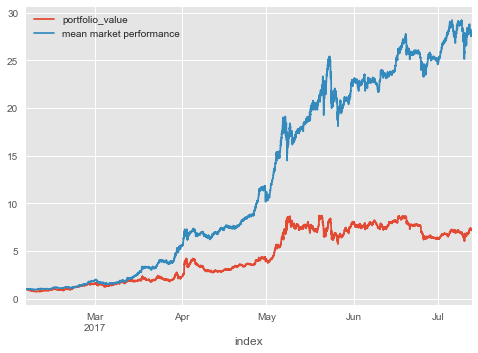

In [29]:
df = pd.DataFrame(env_test.infos)
df.index=df['index']

s=sharpe(df.rate_of_return)
mdd=MDD(df.rate_of_return+1)
mean_market_return=df.mean_market_returns.cumprod().iloc[-1]
print('APV (Accumulated portfolio value): \t{: 2.6f}'.format(df.portfolio_value.iloc[-1]))
print('SR (Sharpe ratio):                 \t{: 2.6f}'.format( s))
print('MDD (max drawdown):                \t{: 2.6%}'.format( mdd))
print('MDR (mean_market_return):          \t{: 2.6f}'.format( mean_market_return))
print('')

# show one run vs average market performance
df.portfolio_value.plot()
df.mean_market_returns.cumprod().plot(label='mean market performance')
plt.legend()